# **Who Votes Whom? Eurovision Song Contest**
### **Analyzing Voting Networks and Song Features in Eurovision**  
### **Are winners chosen by alliances or by the songs themselves?**

**Course:** Social Graphs & Visualization  
**Students:** Áróra Hallmundardóttir, Tinna Sól Björgvinsdóttir, Nanna Kristín Bjarnadóttir


## **1. Introduction**

The Eurovision Song Contest is often presented as a celebration of music, culture, and performance, but decades of public discussion suggest that voting may be shaped just as much by politics, geography, and long-standing alliances as by song quality. This raises an important question: *are winners chosen because of their songs, or because of who votes for whom?*

In this project, we explore this question using a combination of network analysis and song-level feature data. First, we analyze the structure of the Eurovision voting network to identify persistent voting blocs and measure how stable they are across different years. Understanding whether the contest contains consistent alliances is a crucial step in evaluating how much these patterns might influence the final result. In the second part of the project, we examine song characteristics, such as language, genre, and lyrics, to determine whether certain musical or stylistic features correlate with higher point totals.

Together, these two components allow us to compare the relative influence of *alliances* and *song features*, providing insight into whether Eurovision outcomes can be explained by network structure, musical attributes, or a combination of both.


## **2. Data and Pre-Processing**
### 2.1 Data Sources

Our analysis uses three datasets covering Eurovision entries from 2000–2023:

1. **Eurovision Voting Dataset**  
   A structured dataset containing all point exchanges between countries for each contest year.  
   Each row represents a voting event (`from_country → to_country`) with variables including:
   - `year`
   - `from_country`
   - `to_country`
   - `points`

   This dataset forms the foundation for constructing yearly voting networks and detecting voting alliances.

2. **Song Feature Dataset**  
   A metadata dataset containing musical and descriptive attributes for each Eurovision entry, including:
   - `song_title`, `artist`
   - `genre`, `language`
   - musical features (e.g., BPM, energy, danceability, happiness, acousticness)

   This dataset allows us to test whether song characteristics correlate with higher point totals.

3. **Eurovision Song Lyrics Dataset**  
   A Kaggle dataset containing full lyrics for Eurovision entries, including:
   - `year`
   - `country`
   - `artist`
   - `song`
   - `lyrics`
   
   We use these textual data to extract word counts and simple linguistic features, enabling us to evaluate whether lyrical structure or language complexity relates to voting outcomes.

### 2.2 Data Cleaning and Integration

Across these three datasets, we applied the following cleaning procedures:

- Normalized country names to ensure consistency (e.g., merging “Macedonia” → “North Macedonia”).
- Removed invalid, duplicate, or incomplete rows.
- Dropped rows where `year` could not be parsed correctly.
- Restricted the analysis to **2010–2019**, where musical features were consistently available.
- Filtered voting data to include only **final-round votes** (`round = 'f'`).
- Converted relevant columns to numeric values.
- Removed **self-votes** (`from_country = to_country`).
- Removed songs without matching voting records.
- Ensured consistent country naming across datasets.
- Merged vote data with song metadata using:  
  **`left_on=["year", "to_country"]`, `right_on=["year", "country"]`**.

The resulting unified dataset provides one row per vote cast in the Eurovision final, enriched with the musical and lyrical attributes of the receiving country’s entry.


#### Setup: imports and shared constants

We start by importing the required libraries and defining a mapping to normalize country names across datasets.


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)

KEEP_COLS = [
    "year", "round", "from_country", "to_country", "vote_type", "points",
    "artist_name", "song_name", "language", "style", "gender", "main_singers",
    "BPM", "energy", "danceability", "happiness", "acousticness", 
    "instrumentalness", "liveness", "speechiness",
    "semi_place", "semi_total_points", "semi_televote_points", "semi_jury_points",
    "final_place", "final_total_points", "final_televote_points", "final_jury_points",
]

COUNTRY_MAPPING = {
    "Bosnia & Herzegovina": "Bosnia and Herzegovina",
    "F.Y.R. Macedonia": "North Macedonia",
    "Macedonia": "North Macedonia",
    "The Netherlands": "Netherlands",
    "The Netherands": "Netherlands",
    "Netherands": "Netherlands",
    "Netherland": "Netherlands", 
}


### 2.3 Cleaning song metadata (2010–2019)

We clean the song metadata by:
- removing rows with invalid years,
- restricting to entries from 2010–2019,
- normalizing country names,
- trimming text fields, and
- converting musical feature columns to numeric types.


In [2]:
# 1. Load raw songs
df_songs_raw = pd.read_csv("song_data.csv", encoding="latin1")
print("Raw song_data shape:", df_songs_raw.shape)

# 2. Strip whitespace from column names
df_songs_raw.columns = [c.strip() for c in df_songs_raw.columns]

# 3. Remove rows where 'year' is not a clean number
df_songs = df_songs_raw.copy()
df_songs["year"] = pd.to_numeric(df_songs["year"], errors="coerce")
before = len(df_songs)
df_songs = df_songs[df_songs["year"].notna()].copy()
df_songs["year"] = df_songs["year"].astype("Int64")
after = len(df_songs)
print(f"Dropped {before - after} rows with invalid year")

# 4. Keep only years we care about for the analysis (optional but cleaner)
df_songs = df_songs[df_songs["year"].between(2010, 2019)].copy()

# 5. Basic text cleaning
df_songs["country"] = df_songs["country"].astype(str).str.strip()
df_songs["song_name"] = df_songs["song_name"].astype(str).str.strip()

# 6. Normalize country names in songs
df_songs["country"] = df_songs["country"].replace(COUNTRY_MAPPING)

# 7. Convert numeric columns
numeric_cols = [
    "semi_final", "semi_draw_position", "final_draw_position", "final_draw_position_1",
    "BPM", "energy", "danceability", "happiness", "loudness",
    "acousticness", "instrumentalness", "liveness", "speechiness",
    "semi_place", "semi_total_points", "semi_televote_points", "semi_jury_points",
    "final_place", "final_total_points", "final_televote_points", "final_jury_points",
]
for col in numeric_cols:
    if col in df_songs.columns:
        df_songs[col] = pd.to_numeric(df_songs[col], errors="coerce")

# 8. Clean musical key column if present
if "key" in df_songs.columns:
    df_songs["key"] = (
        df_songs["key"].astype(str).str.strip()
        .replace({"unknown": np.nan, "": np.nan})
    )

print("Cleaned song_data shape:", df_songs.shape)
print("Years in songs:", sorted(df_songs["year"].unique()))
df_songs.head()


Raw song_data shape: (565, 44)
Dropped 63 rows with invalid year
Cleaned song_data shape: (372, 44)
Years in songs: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


year  semi_final  semi_draw_position  final_draw_position  \
116  2019         1.0                 1.0                 11.0   
117  2019         1.0                 2.0                  NaN   
118  2019         1.0                 3.0                  NaN   
120  2019         1.0                 5.0                 10.0   
121  2019         1.0                 6.0                  3.0   

            country                    artist_name           song_name  \
116          Cyprus                          Tamta              Replay   
117      Montenegro                          D mol              Heaven   
118         Finland  Darude feat. Sebastian Rejman           Look Away   
120        Slovenia      Zala Kralj & Gasper santl                Sebi   
121  Czech Republic                    Lake Malawi  Friend of a Friend   

    language   style direct_qualifier_10  gender  main_singers      age  \
116  English   Dance                   0  Female           1.0  unknown   
117  English     Pop                   -     Mix           6.0  unknown   
118  English   Dance                   -    Male           1.0  unknown   
120  Slovene  Ballad                   0     Mix           2.0  unknown   
121  English     Pop                   0    Male           1.0  unknown   

    selection      key    BPM  energy  danceability  happiness  loudness  \
116   unknown  B Minor  102.0    68.0          71.0       50.0       NaN   
117   unknown  D Major   92.0    73.0          53.0       47.0       NaN   
118   unknown  B Minor  126.0    89.0          50.0       48.0       NaN   
120   unknown  G Minor  108.0    65.0          78.0       74.0       NaN   
121   unknown  A Minor  106.0    74.0          70.0       41.0       NaN   

     acousticness  instrumentalness  liveness  speechiness release_date  \
116           5.0               0.0       6.0          7.0      unknown   
117          21.0               0.0      31.0          5.0      unknown   
118           1.0               0.0      15.0          5.0      unknown   
120          18.0               2.0      16.0          4.0      unknown   
121          27.0               0.0       7.0          6.0      unknown   

    key_change_10  backing_dancers  backing_singers  backing_instruments  \
116       unknown              4.0              0.0                  0.0   
117       unknown              0.0              0.0                  0.0   
118       unknown              1.0              0.0                  1.0   
120       unknown              0.0              0.0                  0.0   
121       unknown              0.0              0.0                  2.0   

     instrument_10 qualified_10  final_televote_points  final_jury_points  \
116            0.0            1                   32.0               77.0   
117            0.0            0                    NaN                NaN   
118            0.0            0                    NaN                NaN   
120            1.0            1                   59.0               46.0   
121            0.0            1                    7.0              150.0   

     final_televote_votes  final_jury_votes  final_place  final_total_points  \
116                   4.0              15.0         13.0               109.0   
117                   NaN               NaN          NaN                 NaN   
118                   NaN               NaN          NaN                 NaN   
120                  13.0               9.0         15.0               105.0   
121                   4.0              26.0         11.0               157.0   

     semi_place  semi_televote_points  semi_jury_points  semi_total_points  \
116         9.0                  54.0              95.0              149.0   
117        16.0                  15.0              31.0               46.0   
118        17.0                  14.0               9.0               23.0   
120         6.0                  93.0              74.0              167.0   
121         2

### 2.4 Cleaning voting data (finals 2010–2019)

We load the Eurovision voting data, standardize column names, keep only final-round votes, restrict to 2010–2019, and normalize country names to match the song metadata.


In [3]:
votes_file = "eurovision_song_contest_voting_dataset.xlsx"
df_votes = pd.read_excel(votes_file)

# 1. Standardize column names
df_votes.columns = df_votes.columns.str.strip()

df_votes = df_votes.rename(columns={
    "Year": "year",
    "From country": "from_country",
    "To country": "to_country",
    "Jury or Televoting": "vote_type",
    "Points": "points",  # <— fixed here
    "(semi-) final": "round",
})


# 2. Keep only finals ('f')
df_votes = df_votes[df_votes["round"] == "f"].copy()

# 3. Filter years 2010–2019
df_votes["year"] = pd.to_numeric(df_votes["year"], errors="coerce")
df_votes = df_votes[df_votes["year"].between(2010, 2019)].copy()
df_votes["year"] = df_votes["year"].astype("Int64")

# 4. Clean country names
for col in ["from_country", "to_country"]:
    df_votes[col] = df_votes[col].astype(str).str.strip()
    df_votes[col] = df_votes[col].replace(COUNTRY_MAPPING)

print("Voting data shape after cleaning (finals 2010–2019):", df_votes.shape)
print("Years in votes:", sorted(df_votes["year"].unique()))
df_votes.head()


Voting data shape after cleaning (finals 2010–2019): (14807, 8)
Years in votes: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


year round Edition vote_type from_country  to_country  points Duplicate
24984  2010     f   2010f         J      Albania     Albania       0         x
24985  2010     f   2010f         J      Albania     Armenia       0       NaN
24986  2010     f   2010f         J      Albania  Azerbaijan       0       NaN
24987  2010     f   2010f         J      Albania     Belarus       0       NaN
24988  2010     f   2010f         J      Albania     Belgium       0       NaN

### 2.5 Merging voting data with Song Metadata

We merge the cleaned voting data with the cleaned song metadata on (`year`, `to_country`), so that each vote is linked to the song performed by the receiving country in that year.


In [4]:
print("Merging on: ['year', 'to_country'] → songs.country")

merged = pd.merge(
    df_votes,
    df_songs,
    left_on=["year", "to_country"],
    right_on=["year", "country"],
    how="left",
    suffixes=("", "_song")
)

total_votes = len(merged)
missing_rows = merged["song_name"].isna().sum()
print(f"Total votes (2010–2019 finals): {total_votes}")
print(f"Votes without matching song info: {missing_rows} "
      f"({missing_rows / total_votes * 100:.2f}%)")



Merging on: ['year', 'to_country'] → songs.country
Total votes (2010–2019 finals): 14807
Votes without matching song info: 1439 (9.72%)



We remove votes that cannot be matched to a song and drop self-votes (countries voting for themselves), which are not meaningful for alliance analysis.


In [5]:
# Keep rows where we have song info
merged_valid = merged[~merged["song_name"].isna()].copy()
print("After dropping unmatched songs:", merged_valid.shape)

# Remove self-votes (country voting for itself)
before = len(merged_valid)
merged_valid = merged_valid[merged_valid["from_country"] != merged_valid["to_country"]].copy()
after = len(merged_valid)
print(f"Removed {before - after} self-vote rows")


After dropping unmatched songs: (13368, 51)
Removed 213 self-vote rows


### 2.6  Final Analysis Table

Finally, we select the subset of variables needed for our analysis (votes, song metadata, and outcome variables) to create a clean table `clean_final`. Each row represents one vote in the final (2010–2019), linked to the corresponding song features.


In [6]:
clean_final = merged_valid[KEEP_COLS].copy()
print("clean_final shape:", clean_final.shape)
print("Years in clean_final:", sorted(clean_final["year"].unique()))
clean_final.head()


clean_final shape: (13155, 28)
Years in clean_final: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


year round from_country              to_country vote_type  points  \
1  2010     f      Albania                 Armenia         J       0   
2  2010     f      Albania              Azerbaijan         J       0   
3  2010     f      Albania                 Belarus         J       0   
4  2010     f      Albania                 Belgium         J       0   
5  2010     f      Albania  Bosnia and Herzegovina         J       6   

             artist_name              song_name language   style  gender  \
1              Eva Rivas          Apricot Stone  English     Pop  Female   
2                 Safura              Drip Drop  English  Ballad  Female   
3  3+2 feat Robert Wells            Butterflies  English  Ballad     Mix   
4               Tom Dice       Me and My Guitar  English     Pop    Male   
5         Vukasin Brajic  Thunder and Lightning  English    Rock    Male   

   main_singers    BPM  energy  danceability  happiness  acousticness  \
1           1.0  101.0    67.0          61.0       38.0          25.0   
2           1.0  148.0    66.0          47.0       23.0           1.0   
3           5.0    NaN     NaN           NaN        NaN           NaN   
4           1.0  129.0    34.0          47.0       42.0          62.0   
5           1.0    NaN     NaN           NaN        NaN           NaN   

   instrumentalness  liveness  speechiness  semi_place  semi_total_points  \
1               0.0      16.0         10.0         6.0               83.0   
2               0.0       8.0          3.0         2.0              113.0   
3               NaN       NaN          NaN         9.0               59.0   
4               0.0      14.0          3.0         1.0              167.0   
5               NaN       NaN          NaN         8.0               59.0   

   semi_televote_points  semi_jury_points  final_place  final_total_points  \
1                   NaN               NaN          7.0               282.0   
2                   NaN               NaN          5.0               277.0   
3                   NaN               NaN         24.0                40.0   
4                   NaN               NaN          6.0               261.0   
5                   NaN               NaN         17.0                 0.0   

   final_televote_points  final_jury_points  
1                  166.0              116.0  
2                  161.0              116.0  
3                   18.0               22.0  
4                   76.0              185.0  
5                    NaN                NaN

## **3. Network Construction and Voting Patterns**

### 3.1 Building Decade-Level Directed Voting Network
In this step, we construct a **directed voting network** that captures the actual flow of Eurovision points from one country to another.  
Each node represents a country, and each directed edge `A → B` is weighted by the total number of points that *A* awarded to *B* across the selected time period.  

This preserves the asymmetry of Eurovision voting (for example, Iceland may consistently award points to Sweden even if Sweden does not reciprocate).  
The directed structure therefore provides the most faithful representation of the raw voting behavior before converting the network into an undirected form for community detection.


In [7]:
import networkx as nx
import pandas as pd

# Use the cleaned final dataset
df = clean_final.copy()

# Aggregate points across ALL years (2010–2023)
edge_weights = (
    df.groupby(["from_country", "to_country"])["points"]
      .sum()
      .reset_index()
)

# Create directed graph
G = nx.DiGraph()

# Add nodes
countries = sorted(set(edge_weights["from_country"]).union(edge_weights["to_country"]))
G.add_nodes_from(countries)

# Add weighted edges
for _, row in edge_weights.iterrows():
    if row["points"] > 0:   # Eurovision gives many 0s; we keep only positive ties
        G.add_edge(row["from_country"], row["to_country"], weight=row["points"])

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Nodes: 46
Edges: 1665


### 3.2 In-degree and Out-degree Points: Who gives and receives

We compute:
- **in-points**: total points a country *receives*  
- **out-points**: total points a country *gives*  

This identifies which countries are most rewarded and which ones distribute points the most generously.


In [8]:
import pandas as pd

# Convert centrality into a DataFrame
in_deg = pd.DataFrame(G.in_degree(weight="weight"), columns=["country", "in_points"])
out_deg = pd.DataFrame(G.out_degree(weight="weight"), columns=["country", "out_points"])

# Merge into one table
centrality_df = pd.merge(in_deg, out_deg, on="country")

# Sort by points received
centrality_df_sorted = centrality_df.sort_values("in_points", ascending=False)
centrality_df_sorted.head(15)


country  in_points  out_points
41       Sweden       2415         737
23        Italy       1565         626
35       Russia       1517         663
4    Azerbaijan       1371         713
29  Netherlands       1274         753
2     Australia       1067         445
31       Norway       1056         731
6       Belgium        975         704
12      Denmark        962         756
3       Austria        940         687
22       Israel        906         688
17      Germany        901         719
33     Portugal        840         571
44      Ukraine        825         555
10       Cyprus        812         671

### 3.3 Net Gain: Which Countries Receive More Than They Give?

To understand which countries benefit the most from the Eurovision voting system, we compute a simple **net gain** measure:

**balance = total points received – total points given**

A high balance means a country **receives far more points than it gives**, which can indicate strong popularity, consistent musical appeal, or favorable voting relationships.

However, the raw balance can be misleading because:

- Not all countries participate every year.  **Útskýra þetta er vegna þeir komust ekki í final**
- Countries with fewer appearances naturally give fewer points. **Þó þeir komust ekki í final þá kjósa þeir samt?**

To correct for this, we compute a **normalized balance**:

- We count how many years each country participates.  
- We divide their outgoing points by the number of years (points given per year).  
- We then compare this to the total points they receive.

This creates a fairer view of which countries are true **net receivers** of points over time.

After normalization, countries like **Sweden, Italy, Russia, Azerbaijan, and Australia** still stand out as consistently receiving significantly more points than they give, even after adjusting for participation differences.


In [9]:
participation = clean_final.groupby("from_country")["year"].nunique().reset_index(name="years")
# Merge centrality with number of years participated
centrality_norm = centrality_df.merge(
    participation, left_on="country", right_on="from_country"
)

# Compute normalized outgoing points per participation year
centrality_norm["out_points_per_year"] = (
    centrality_norm["out_points"] / centrality_norm["years"]
)

# Compute balance score: points received minus normalized points given
centrality_norm["balance"] = (
    centrality_norm["in_points"] - centrality_norm["out_points_per_year"]
)

# Clean up redundant column
centrality_norm = centrality_norm.drop(columns=["from_country"])

# Show top 10 "net receivers" countries
centrality_norm.sort_values("balance", ascending=False).head(10)


country  in_points  out_points  years  out_points_per_year  \
41       Sweden       2415         737     10            73.700000   
23        Italy       1565         626      9            69.555556   
35       Russia       1517         663      9            73.666667   
4    Azerbaijan       1371         713     10            71.300000   
29  Netherlands       1274         753     10            75.300000   
31       Norway       1056         731     10            73.100000   
2     Australia       1067         445      5            89.000000   
6       Belgium        975         704     10            70.400000   
12      Denmark        962         756     10            75.600000   
3       Austria        940         687      9            76.333333   

        balance  
41  2341.300000  
23  1495.444444  
35  1443.333333  
4   1299.700000  
29  1198.700000  
31   982.900000  
2    978.000000  
6    904.600000  
12   886.400000  
3    863.666667

### 3.4 Reciprocity: How Mutual Is Eurovision Voting?

Eurovision voting is directed - Country A gives points to Country B, but B may not return the favor.  
To measure how *mutual* the voting is, we compute **reciprocity**, defined as the proportion of directed edges that go both ways.

- A reciprocity of **1.0** means every voting relationship is perfectly mutual.  
- A reciprocity close to **0** would mean countries rarely exchange points in both directions.  

In the Eurovision context, high reciprocity suggests the presence of **stable bilateral voting relationships**, reflecting regional ties, shared culture, or diaspora communities.

The following code calculates the global reciprocity of the full decade voting network.


In [10]:
import networkx as nx

reciprocity_global = nx.reciprocity(G)
print("Overall reciprocity of the directed voting network:", reciprocity_global)


Overall reciprocity of the directed voting network: 0.8408408408408409


### 3.5 Strongest Mutual Voting Alliances

While global reciprocity tells us how mutual the network is overall, it is also useful to look at **which specific country pairs exchange points in both directions**.

A *reciprocal pair* is defined as:

- Country A → Country B **and**  
- Country B → Country A  
both occurring at least once during 2010–2019.

These pairs often reflect well-known cultural, linguistic, or regional relationships (e.g., Greece–Cyprus, Sweden–Denmark, Russia–Azerbaijan).

The following code counts how many such mutual pairs exist and prints a sample of the strongest ones.


In [11]:
reciprocal_pairs = []
for u, v in G.edges():
    if G.has_edge(v, u):
        reciprocal_pairs.append((u, v))

print("Number of mutual voting pairs:", len(reciprocal_pairs))
reciprocal_pairs[:20]


Number of mutual voting pairs: 1400


[('Albania', 'Austria'),
 ('Albania', 'Azerbaijan'),
 ('Albania', 'Belgium'),
 ('Albania', 'Bosnia and Herzegovina'),
 ('Albania', 'Bulgaria'),
 ('Albania', 'Cyprus'),
 ('Albania', 'Czech Republic'),
 ('Albania', 'Denmark'),
 ('Albania', 'Germany'),
 ('Albania', 'Greece'),
 ('Albania', 'Hungary'),
 ('Albania', 'Ireland'),
 ('Albania', 'Italy'),
 ('Albania', 'Malta'),
 ('Albania', 'Montenegro'),
 ('Albania', 'North Macedonia'),
 ('Albania', 'Poland'),
 ('Albania', 'Portugal'),
 ('Albania', 'Romania'),
 ('Albania', 'Russia')]

#### Strength of Mutual Voting Between Country Pairs

Counting reciprocal pairs tells us who *mutually* exchanges points, but it does not tell us **how strong** those relationships are.

To quantify this, we calculate **mutual voting strength**:

This captures long-term alliances more meaningfully.  
For example, Greece ↔ Cyprus consistently give each other high points, so they should appear at the top.

The code below computes total mutual points exchanged for every reciprocal country pair and lists the strongest alliances from 2010–2019.


In [12]:
import numpy as np

mutual_strength = []

for u, v in G.edges():
    if G.has_edge(v, u):
        w_uv = G[u][v]["weight"]
        w_vu = G[v][u]["weight"]
        mutual_strength.append((u, v, w_uv + w_vu))

# Sort by total mutual points
mutual_strength_sorted = sorted(mutual_strength, key=lambda x: -x[2])
mutual_strength_sorted[:15]


[('Cyprus', 'Greece', 218),
 ('Greece', 'Cyprus', 218),
 ('Denmark', 'Sweden', 180),
 ('Sweden', 'Denmark', 180),
 ('Azerbaijan', 'Russia', 170),
 ('Russia', 'Azerbaijan', 170),
 ('Norway', 'Sweden', 166),
 ('Sweden', 'Norway', 166),
 ('Belgium', 'Netherlands', 142),
 ('Netherlands', 'Belgium', 142),
 ('Azerbaijan', 'Georgia', 140),
 ('Georgia', 'Azerbaijan', 140),
 ('Netherlands', 'Sweden', 140),
 ('Sweden', 'Netherlands', 140),
 ('Azerbaijan', 'Ukraine', 136)]

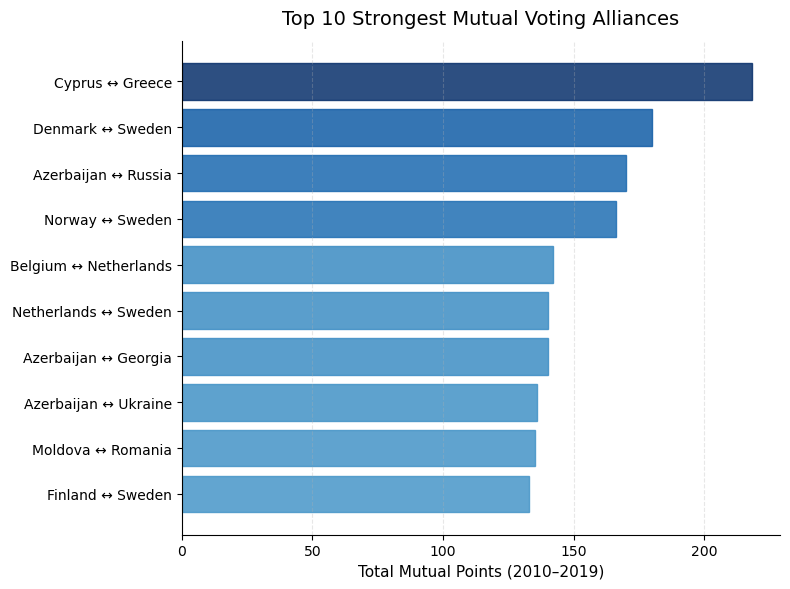

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert top mutual pairs to dataframe (deduplicate A↔B)
pair_scores = {}
for u, v, w in mutual_strength_sorted:
    key = tuple(sorted([u, v]))
    if key not in pair_scores:
        pair_scores[key] = w

# Take top 10 strongest mutual pairs
top10 = sorted(pair_scores.items(), key=lambda x: -x[1])[:10]

df_top = pd.DataFrame(
    [{"pair": f"{a} ↔ {b}", "mutual_points": w} for (a, b), w in top10]
).sort_values("mutual_points")

plt.figure(figsize=(8, 6))

bars = plt.barh(
    df_top["pair"],
    df_top["mutual_points"],
    alpha=0.85
)

# Use a colormap for smooth coloring
cmap = plt.cm.Blues
norm_vals = df_top["mutual_points"] / df_top["mutual_points"].max()
for bar, val in zip(bars, norm_vals):
    bar.set_color(cmap(val))

plt.xlabel("Total Mutual Points (2010–2019)", fontsize=11)
plt.title("Top 10 Strongest Mutual Voting Alliances", fontsize=14, pad=12)

# Remove spines for a cleaner look
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Add light dashed grid
plt.grid(axis="x", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


***Figure 1:*** *Top 10 strongest mutual voting alliances between Eurovision countries (2010–2019). Bars show the total number of points exchanged reciprocally between each pair across all finals in the decade.*

### 3.6 Which Countries Receive the Most Points?

Before looking at voting blocs, it is useful to identify **which countries are the most successful in terms of total points received**.

Using the directed voting network, we compute:

- **in_points**: how many points each country received (from all other countries)
- We then rank countries by their total incoming points across 2010–2019.

This highlights which countries consistently perform well *regardless of alliances*.

The plot below shows the **Top 10 most voted-for countries** during the decade.


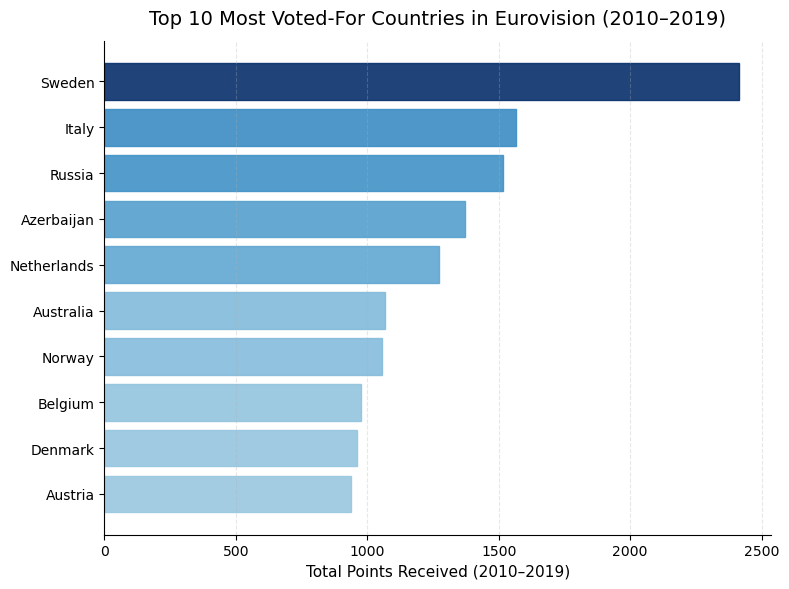

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure centrality_df exists; if not, recompute quickly
in_deg = pd.DataFrame(G.in_degree(weight="weight"), columns=["country", "in_points"])
out_deg = pd.DataFrame(G.out_degree(weight="weight"), columns=["country", "out_points"])
centrality_df = pd.merge(in_deg, out_deg, on="country")

# Top 10 countries by points received
top10_in = centrality_df.sort_values("in_points", ascending=False).head(10)
top10_in = top10_in.sort_values("in_points")  # reverse for clean horizontal plot

plt.figure(figsize=(8, 6))

# Bars
bars = plt.barh(
    top10_in["country"],
    top10_in["in_points"],
    alpha=0.9
)

# Smooth gradient colormap
cmap = plt.cm.Blues
norm_vals = top10_in["in_points"] / top10_in["in_points"].max()

for bar, val in zip(bars, norm_vals):
    bar.set_color(cmap(val))

# Labels and style
plt.xlabel("Total Points Received (2010–2019)", fontsize=11)
plt.title("Top 10 Most Voted-For Countries in Eurovision (2010–2019)", fontsize=14, pad=12)

# Remove top/right borders for modern style
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Light grid
plt.grid(axis="x", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


***Figure 2:*** *Top 10 most voted-for countries in Eurovision finals (2010–2019). Bars indicate the total number of points received from all other countries across the decade*

### 3.7 Heatmap of Mutual Voting

To visualize how strongly every pair of countries exchanges points, we construct a **full mutual voting matrix**:

- Each cell \((i, j)\) represents the **total number of points exchanged in both directions** between countries *i* and *j* from 2010–2019.
- A **logarithmic color scale** is used because mutual point totals vary widely, and log-scaling makes both weak and strong relationships visible.

This heatmap provides a global overview of Eurovision’s voting landscape, revealing:
- strong bilateral alliances (bright blocks),
- weaker or rare exchanges (dark areas),
- and broader regional structures.

It serves as a bridge between simple reciprocity measures and formal community detection.


In [15]:
import numpy as np
import pandas as pd
import plotly.express as px

# --- Build FULL mutual matrix from mutual_strength_sorted ---

pair_scores = {}
for u, v, w in mutual_strength_sorted:
    key = tuple(sorted([u, v]))
    if key not in pair_scores:
        pair_scores[key] = w

countries = sorted(set([c for pair in pair_scores for c in pair]))
n = len(countries)

mat_full = np.zeros((n, n))
for (c1, c2), w in pair_scores.items():
    i = countries.index(c1)
    j = countries.index(c2)
    mat_full[i, j] = w
    mat_full[j, i] = w

# optional: clip extremes so the colour scale isn't dominated by a few pairs
nonzero = mat_full[mat_full > 0]
vmax = np.percentile(nonzero, 95) if len(nonzero) > 0 else None

# --- Put into a DataFrame ---
df_heat = pd.DataFrame(mat_full, index=countries, columns=countries)

# --- Plotly interactive heatmap ---
fig = px.imshow(
    df_heat,
    labels=dict(x="Receiving country", y="Giving country", color="Mutual points"),
    x=countries,
    y=countries,
    color_continuous_scale="Blues",   # 🔵 BLUE THEME
    zmin=0,
    zmax=vmax,
    aspect="auto",
)

fig.update_layout(
    title="Mutual Voting Heatmap (All Countries, 2010–2019)",
    width=900,
    height=800,
    xaxis_nticks=len(countries),
    yaxis_nticks=len(countries),
)
fig.update_xaxes(tickangle=90)

fig.show()


***Figure 3:*** *Top 10 strongest mutual voting alliances between Eurovision countries (2010–2019). Bars show the total number of points exchanged reciprocally between each pair across all finals in the decade.*

#### Strongest Mutual Voting Alliances (Top 10 Pairs)

While the full mutual-voting heatmap shows the global structure of pairwise exchanges, it can be helpful to zoom in on the **strongest bilateral relationships**.  
In this step, we identify the **top 10 country pairs** that exchanged the highest total amount of points between 2010–2019.

To do this, we:

- Combine votes in both directions (\(i \rightarrow j\) and \(j \rightarrow i\)).
- Deduplicate pairs so (Greece, Cyprus) and (Cyprus, Greece) count as a single relationship.
- Select the 10 pairs with the highest total mutual score.
- Visualize them in a compact heatmap showing only these countries.

This highlights the most iconic Eurovision “alliances,” such as:
- **Greece–Cyprus**,  
- **Sweden–Denmark**,  
- **Azerbaijan–Russia**,  
- **Belgium–Netherlands**, etc.

These are the pairs that contribute most strongly to the perception of regional or culturally driven voting patterns.


In [16]:
import numpy as np
import pandas as pd
import plotly.express as px

# --- Deduplicate pairs ---
pair_scores = {}
for u, v, w in mutual_strength_sorted:
    key = tuple(sorted([u, v]))
    if key not in pair_scores:
        pair_scores[key] = w

# --- Top 10 mutual pairs ---
top_pairs = sorted(pair_scores.items(), key=lambda x: -x[1])[:10]

# Collect all countries in those 10 pairs
countries = sorted(set([c for pair, _ in top_pairs for c in pair]))
n = len(countries)

# --- Build full matrix (only top 10 pairs, rest = 0) ---
mat = np.zeros((n, n))
for (c1, c2), w in top_pairs:
    i = countries.index(c1)
    j = countries.index(c2)
    mat[i, j] = w
    mat[j, i] = w

# Clip top values for nicer contrast (avoid washed-out light colors)
nonzero = mat[mat > 0]
vmax = np.percentile(nonzero, 90) if len(nonzero) > 0 else None

# --- Put into DataFrame ---
df_heat = pd.DataFrame(mat, index=countries, columns=countries)

# --- Interactive Plotly Heatmap ---
fig = px.imshow(
    df_heat,
    labels=dict(
        x="Country",
        y="Country",
        color="Mutual points"
    ),
    x=countries,
    y=countries,
    color_continuous_scale="Blues",
    zmin=0,
    zmax=vmax,
    aspect="auto",
)

fig.update_layout(
    title="Top 10 Strongest Mutual Voting Alliances (Full Matrix)",
    width=900,
    height=800,
    template="plotly_white",
)

fig.update_xaxes(tickangle=90)

fig.show()


***Figure 4:*** *Top 10 strongest mutual voting alliances between Eurovision countries (2010–2019). Bars show the total number of points exchanged reciprocally between each pair across all finals in the decade.*

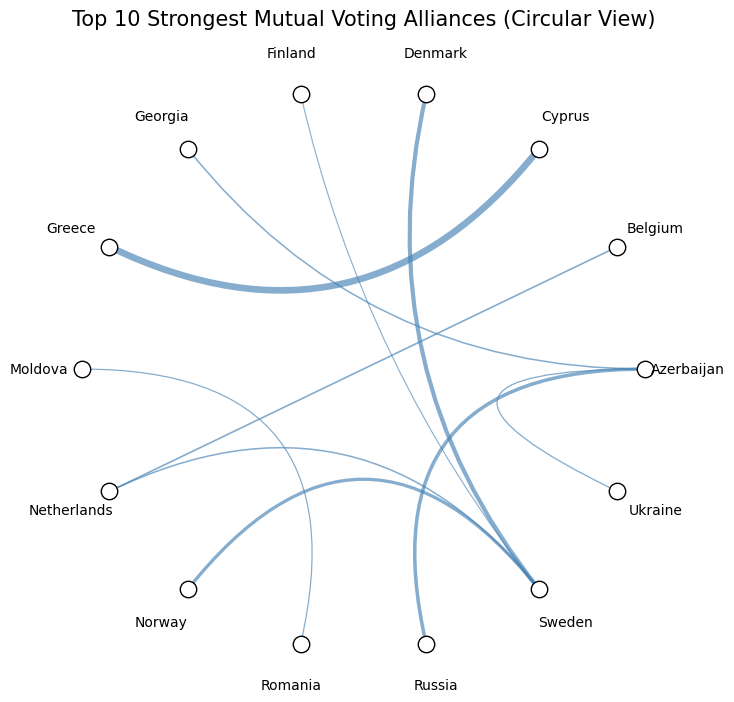

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# --- Deduplicate pairs like (Greece, Cyprus) / (Cyprus, Greece) ---
pair_scores = {}
for u, v, w in mutual_strength_sorted:
    key = tuple(sorted([u, v]))
    if key not in pair_scores:
        pair_scores[key] = w

# --- Take top 10 strongest mutual pairs ---
top_pairs = sorted(pair_scores.items(), key=lambda x: -x[1])[:10]

# --- Unique countries in these pairs ---
countries = sorted(set([c for (c1, c2), _ in top_pairs for c in (c1, c2)]))
n = len(countries)

# --- Position countries evenly on a circle ---
theta = np.linspace(0, 2*np.pi, n, endpoint=False)
pos = {c: (np.cos(t), np.sin(t)) for c, t in zip(countries, theta)}

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.axis("off")

# --- Draw nodes (countries on circle) ---
for c, (x, y) in pos.items():
    ax.scatter(x, y, s=140, color="white", edgecolor="black", zorder=3)
    ax.text(x * 1.15, y * 1.15, c, ha="center", va="center", fontsize=10)

# --- Edge thickness scaling ---
weights = [w for (_, _), w in top_pairs]
w_min, w_max = min(weights), max(weights)

# --- Draw curved edges (Bezier curves via center) ---
for (c1, c2), w in top_pairs:
    x1, y1 = pos[c1]
    x2, y2 = pos[c2]

    # thickness
    width = 0.8 + 4 * (w - w_min) / (w_max - w_min + 1e-9)

    # curved path: country A → center → country B
    verts = [
        (x1, y1),
        (0, 0),      # control point
        (x2, y2),
    ]
    codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]

    path = Path(verts, codes)
    patch = PathPatch(
        path,
        lw=width,
        edgecolor="steelblue",
        facecolor="none",
        alpha=0.65,
        zorder=1,
    )
    ax.add_patch(patch)

plt.title(
    "Top 10 Strongest Mutual Voting Alliances (Circular View)",
    fontsize=15,
    pad=30
)
plt.show()


***Figure 5:*** *Circular visualization of the Top 10 strongest mutual voting alliances in Eurovision (2010–2019).
Each country is placed around a circle, with curved edges representing pairs of countries that exchanged the highest total number of points across the decade.
Thicker curves indicate stronger mutual support. The Cyprus–Greece and Sweden–Norway links stand out as some of the strongest and most consistent alliances during this period.*

## 4. Community Structure in the Decade-Level Network

### 4.1 Undirected Graph for Community Detection

To detect voting communities, we convert the directed Eurovision voting network into an **undirected weighted graph**.  
Although countries give points directionally, community detection algorithms used in this course (such as **Louvain**) require an undirected graph.

In this step:
- Each country is a node.  
- Two countries are connected if they exchanged any points across 2010–2019.  
- The edge weight becomes the **total points exchanged in both directions**.

This undirected representation captures the overall *strength of relationships* between countries and allows Louvain to identify long-term voting blocs.


In [18]:
G_und = nx.Graph()

for u, v, data in G.edges(data=True):
    w = data["weight"]
    if G_und.has_edge(u, v):
        G_und[u][v]["weight"] += w
    else:
        G_und.add_edge(u, v, weight=w)

print("Undirected graph created.")
print("Nodes:", G_und.number_of_nodes())
print("Edges:", G_und.number_of_edges())


Undirected graph created.
Nodes: 46
Edges: 965


### 4.2 Louvain community detection on the Decade Network


To find groups of countries that tend to vote for each other, we apply the **Louvain community detection** algorithm to our undirected voting network.  
Louvain is the method we covered in the course for discovering communities based on connection strength.

We use a resolution value of **1.25**, which gives blocs that are neither too large nor too fragmented.  
At this setting, the communities match well with geographical and cultural regions, which makes the results easier to interpret.

The code below runs Louvain, reports the modularity score, and prints out the countries in each detected community.



In [19]:
from networkx.algorithms.community.louvain import louvain_communities
from networkx.algorithms.community.quality import modularity

RESOLUTION = 1.25

communities_res125 = louvain_communities(
    G_und,
    weight="weight",
    seed=0,
    resolution=RESOLUTION
)

Q_res125 = modularity(G_und, communities_res125, weight="weight")

print(f"\nLouvain (resolution={RESOLUTION}):")
print(f" Modularity: {Q_res125:.3f}")
print(f" Number of communities: {len(communities_res125)}\n")

for i, comm in enumerate(communities_res125):
    print(f"Community {i+1} ({len(comm)} countries):")
    print(", ".join(sorted(comm)))
    print()



Louvain (resolution=1.25):
 Modularity: 0.113
 Number of communities: 7

Community 1 (6 countries):
Austria, Belgium, Germany, Netherlands, Poland, Switzerland

Community 2 (3 countries):
Bulgaria, Cyprus, Greece

Community 3 (3 countries):
Italy, Malta, San Marino

Community 4 (9 countries):
Albania, Bosnia and Herzegovina, Croatia, Hungary, Montenegro, North Macedonia, Serbia, Slovenia, Turkey

Community 5 (4 countries):
France, Portugal, Romania, Spain

Community 6 (13 countries):
Australia, Czech Republic, Denmark, Estonia, Finland, Iceland, Ireland, Latvia, Lithuania, Norway, Slovakia, Sweden, United Kingdom

Community 7 (8 countries):
Armenia, Azerbaijan, Belarus, Georgia, Israel, Moldova, Russia, Ukraine



### 4.4 Visualizing the Louvain Voting Communities

To check how the detected blocs appear in the voting network itself, we plot the decade-level undirected graph with nodes colored by their community (resolution = 1.25).  
Countries in the same bloc cluster together in the layout, giving a quick visual sense of how strongly each group is internally connected.


In [20]:
country_to_flagfile = {
    "Sweden": "flags/Sweden.png",
    "Norway": "flags/Norway.png",
    "United Kingdom": "flags/United_Kingdom.png",
    # ... add all countries in your graph
}


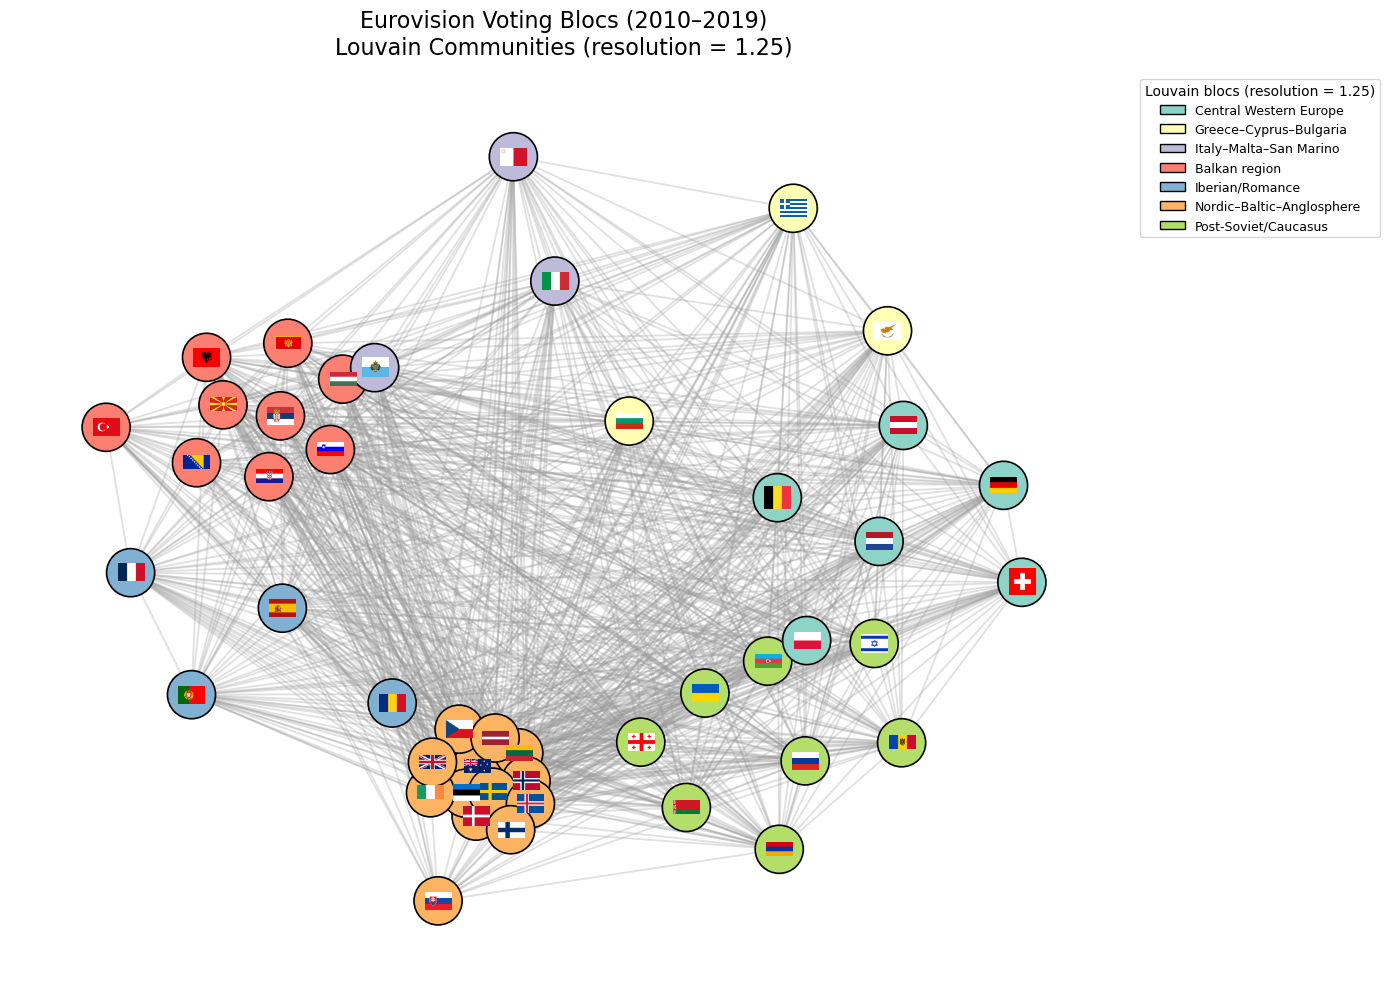

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from io import BytesIO
import requests
import numpy as np

# --- ISO country codes (unchanged) ---
country_to_iso = {
    "Albania": "AL",
    "Armenia": "AM",
    "Australia": "AU",
    "Austria": "AT",
    "Azerbaijan": "AZ",
    "Belarus": "BY",
    "Belgium": "BE",
    "Bosnia and Herzegovina": "BA",
    "Bulgaria": "BG",
    "Croatia": "HR",
    "Cyprus": "CY",
    "Czech Republic": "CZ",
    "Denmark": "DK",
    "Estonia": "EE",
    "Finland": "FI",
    "France": "FR",
    "Georgia": "GE",
    "Germany": "DE",
    "Greece": "GR",
    "Hungary": "HU",
    "Iceland": "IS",
    "Ireland": "IE",
    "Israel": "IL",
    "Italy": "IT",
    "Latvia": "LV",
    "Lithuania": "LT",
    "Malta": "MT",
    "Moldova": "MD",
    "Montenegro": "ME",
    "Netherlands": "NL",
    "North Macedonia": "MK",
    "Norway": "NO",
    "Poland": "PL",
    "Portugal": "PT",
    "Romania": "RO",
    "Russia": "RU",
    "San Marino": "SM",
    "Serbia": "RS",
    "Slovakia": "SK",
    "Slovenia": "SI",
    "Spain": "ES",
    "Sweden": "SE",
    "Switzerland": "CH",
    "Turkey": "TR",
    "Ukraine": "UA",
    "United Kingdom": "GB",
}

# --- Nice names for blocs (legend labels) ---
bloc_names = {
    0: "Central Western Europe",
    1: "Greece–Cyprus–Bulgaria",
    2: "Italy–Malta–San Marino",
    3: "Balkan region",
    4: "Iberian/Romance",
    5: "Nordic–Baltic–Anglosphere",
    6: "Post-Soviet/Caucasus",
}

# === Graph & communities ===
communities = communities_res125      # list of sets
G = G_und                             # undirected decade graph

node2com = {node: cid for cid, comm in enumerate(communities) for node in comm}
com_ids = sorted(set(node2com.values()))

# --- community-aware layout: cluster blocs & spread them ---
def community_cluster_layout(G, communities, community_radius=4.0,
                             internal_scale=1.6, seed=42):
    """
    Place each community on a big circle (community_radius),
    then run a spring layout inside each community and scale it
    by internal_scale to spread nodes within the bloc.
    """
    np.random.seed(seed)
    comms = [list(c) for c in communities]
    k = len(comms)

    angles = np.linspace(0, 2*np.pi, k, endpoint=False)
    pos = {}

    for idx, comm in enumerate(comms):
        subG = G.subgraph(comm)

        # spring layout INSIDE community
        sub_pos = nx.spring_layout(
            subG,
            k=0.7,
            iterations=300,
            weight="weight",
            seed=seed
        )

        # center position for this community
        cx = community_radius * np.cos(angles[idx])
        cy = community_radius * np.sin(angles[idx])

        # shift + scale internal structure
        for node, (x, y) in sub_pos.items():
            pos[node] = np.array([
                cx + internal_scale * x,
                cy + internal_scale * y
            ])

    return pos

pos = community_cluster_layout(
    G,
    communities,
    community_radius=4.3,   # distance between communities (bigger = more spread)
    internal_scale=1.8,     # spread nodes inside each community
    seed=42
)

# --- Colors per community ---
base_cmap = matplotlib.colormaps["Set3"]
cmap = ListedColormap(base_cmap.colors[:len(com_ids)])
node_colors = [node2com[n] for n in G.nodes()]

plt.figure(figsize=(14, 10))
plt.rcParams["font.family"] = "DejaVu Sans"
ax = plt.gca()

# ---- EDGES: slightly stronger but still light ----
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.30,
    width=1.3,
    edge_color="#999999",
    ax=ax
)

# ---- NODES: colored discs for blocs ----
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=1200,
    node_color=node_colors,
    cmap=cmap,
    edgecolors="black",
    linewidths=1.2,
    ax=ax
)

# ---------- FLAGS on top of nodes ----------
_flag_cache = {}

def get_flag_image(iso2):
    if iso2 is None:
        return None
    iso2 = iso2.lower()
    if iso2 in _flag_cache:
        return _flag_cache[iso2]
    url = f"https://flagcdn.com/w40/{iso2}.png"
    resp = requests.get(url)
    if resp.status_code != 200:
        return None
    img = plt.imread(BytesIO(resp.content), format="png")
    _flag_cache[iso2] = img
    return img

for node, (x, y) in pos.items():
    iso2 = country_to_iso.get(node)
    img = get_flag_image(iso2)
    if img is None:
        continue
    im = OffsetImage(img, zoom=0.47)
    ab = AnnotationBbox(im, (x, y), frameon=False)
    ax.add_artist(ab)

# --- Legend with bloc NAMES instead of "Community 1" ---
handles = []
for cid in com_ids:
    label = bloc_names.get(cid, f"Community {cid+1}")
    handles.append(Patch(facecolor=cmap(cid), edgecolor="black", label=label))

plt.legend(
    handles=handles,
    title="Louvain blocs (resolution = 1.25)",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.,
    fontsize=9
)

plt.title(
    "Eurovision Voting Blocs (2010–2019)\nLouvain Communities (resolution = 1.25)",
    fontsize=16,
    pad=18
)
plt.axis("off")
plt.tight_layout()

# --- SAVE + SHOW ---
plt.savefig("eurovision_louvain_blocs.png", dpi=300, bbox_inches="tight")
plt.show()


***Figure 5:*** *Network visualization of Eurovision voting (2010–2019), with nodes representing countries and colors indicating Louvain communities. Edge density reflects the intensity of voting connections.*

### 4.5 Geographic Map of Voting Blocs

To visualize how the detected voting blocs align with real-world geography,  
we project each country onto a European map (using approximate coordinates)  
and color the markers by their Louvain community (resolution = 1.25).

We also draw the **strongest voting ties** between countries — specifically,  
the top 25% of all undirected edge weights — which highlight the most persistent  
and influential voting relationships in the decade-long network.

This map allows us to see:

- whether bloc members are geographically close,  
- which regions have dense internal voting links,  
- and how strong alliances (e.g., Greece–Cyprus, Nordic cluster) appear spatially.

Strong intra-bloc connections are shown as light grey lines, while countries  
are colored according to the bloc they belong to.


In [22]:
import folium
import pandas as pd
import numpy as np

# --- 1. Coordinates for countries (approx, center of country) ---
# If you already have `country_coords` defined, you can skip this block.
country_coords = {
    "Albania": (41.1, 20.0),
    "Armenia": (40.1, 45.0),
    "Australia": (-25.0, 133.0),
    "Austria": (47.7, 13.3),
    "Azerbaijan": (40.1, 47.5),
    "Belarus": (53.7, 27.9),
    "Belgium": (50.8, 4.4),
    "Bosnia and Herzegovina": (43.9, 17.7),
    "Bulgaria": (42.7, 25.5),
    "Croatia": (45.1, 15.2),
    "Cyprus": (35.1, 33.4),
    "Czech Republic": (49.8, 15.5),
    "Denmark": (56.0, 10.0),
    "Estonia": (58.6, 25.0),
    "Finland": (64.0, 26.0),
    "France": (46.2, 2.2),
    "Georgia": (42.3, 43.5),
    "Germany": (51.2, 10.4),
    "Greece": (39.1, 22.9),
    "Hungary": (47.1, 19.5),
    "Iceland": (64.9, -18.6),
    "Ireland": (53.1, -8.2),
    "Israel": (31.0, 34.8),
    "Italy": (41.9, 12.5),
    "Latvia": (56.9, 24.6),
    "Lithuania": (55.2, 23.8),
    "Malta": (35.9, 14.4),
    "Moldova": (47.0, 28.8),
    "Montenegro": (42.7, 19.3),
    "Netherlands": (52.1, 5.3),
    "North Macedonia": (41.6, 21.7),
    "Norway": (61.2, 8.5),
    "Poland": (52.1, 19.1),
    "Portugal": (39.4, -8.2),
    "Romania": (45.9, 24.9),
    "Russia": (55.0, 37.6),
    "San Marino": (43.9, 12.5),
    "Serbia": (44.0, 21.0),
    "Slovakia": (48.7, 19.7),
    "Slovenia": (46.1, 14.9),
    "Spain": (40.5, -3.7),
    "Sweden": (60.0, 15.0),
    "Switzerland": (46.8, 8.3),
    "Turkey": (39.0, 35.0),
    "Ukraine": (49.0, 31.0),
    "United Kingdom": (55.4, -3.4),
}

# --- 2. Map each country to its bloc id (community id) ---
country_to_bloc = {}
for bloc_id, comm in enumerate(communities):
    for c in comm:
        country_to_bloc[c] = bloc_id

# Optional: you can later map bloc_id -> name, e.g.
bloc_names = {
    0: "Central Western Europe",
    1: "Greece–Cyprus–Bulgaria",
    2: "Italy–Malta–San Marino",
    3: "Balkan region",
    4: "Iberian/Romance",
    5: "Nordic–Baltic–Anglosphere",
    6: "Post-Soviet/Caucasus",
}

# --- 3. Countries dataframe (markers) ---
countries = []
for c in G_und.nodes():
    if c not in country_coords:
        continue
    lat, lon = country_coords[c]
    bloc = country_to_bloc.get(c, -1)
    bloc_label = bloc_names.get(bloc, f"Bloc {bloc}")
    countries.append({
        "country": c,
        "lat": lat,
        "lon": lon,
        "bloc": bloc,
        "bloc_label": bloc_label,
    })

countries_df = pd.DataFrame(countries)

# --- 4. Edges dataframe (strong ties only) ---
edge_rows = []
for u, v, data in G_und.edges(data=True):
    if u not in country_coords or v not in country_coords:
        continue
    w = data.get("weight", 0)
    edge_rows.append({
        "u": u,
        "v": v,
        "weight": w,
        "u_lat": country_coords[u][0],
        "u_lon": country_coords[u][1],
        "v_lat": country_coords[v][0],
        "v_lon": country_coords[v][1],
        "same_bloc": country_to_bloc.get(u) == country_to_bloc.get(v),
    })

edges_df = pd.DataFrame(edge_rows)

# keep only strong edges (e.g. top 25%)
w_thresh = edges_df["weight"].quantile(0.75)
edges_strong = edges_df[edges_df["weight"] >= w_thresh].copy()
import folium

# Color palette for blocs (simple)
bloc_colors = {
    0: "blue",
    1: "orange",
    2: "red",
    3: "green",
    4: "purple",
    5: "cadetblue",
    6: "darkred",
    -1: "gray",
}

# Create map centered on Europe
m_blocs = folium.Map(
    location=[50, 15],
    zoom_start=4,
    tiles="cartodbpositron",
)

# Add country markers
for _, row in countries_df.iterrows():
    color = bloc_colors.get(row["bloc"], "gray")
    tooltip = f"{row['country']} — {row['bloc_label']}"
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=6,
        color="black",
        weight=1,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        tooltip=tooltip,
    ).add_to(m_blocs)

# Add strong edges (you can set same_bloc_only = True to simplify)
same_bloc_only = True

for _, row in edges_strong.iterrows():
    if same_bloc_only and not row["same_bloc"]:
        continue

    folium.PolyLine(
        locations=[
            [row["u_lat"], row["u_lon"]],
            [row["v_lat"], row["v_lon"]],
        ],
        weight=1 + (row["weight"] / edges_strong["weight"].max()) * 4,
        color="gray",
        opacity=0.5,
        tooltip=f"{row['u']} ↔ {row['v']} ({row['weight']:.0f} points total)",
    ).add_to(m_blocs)

m_blocs
# optionally: m_blocs.save("eurovision_blocs_map.html")


***Figure 6:*** *Geographical visualization of Eurovision voting blocs (2010–2019). Countries are placed at their coordinates, colored by community, with edges showing aggregated voting ties between blocs*

In [23]:
import folium
import pandas as pd
import numpy as np

# --- 1. Coordinates for countries (approx, center of country) ---
# If you already have `country_coords` defined, you can skip this block.
country_coords = {
    "Albania": (41.1, 20.0),
    "Armenia": (40.1, 45.0),
    "Australia": (-25.0, 133.0),
    "Austria": (47.7, 13.3),
    "Azerbaijan": (40.1, 47.5),
    "Belarus": (53.7, 27.9),
    "Belgium": (50.8, 4.4),
    "Bosnia and Herzegovina": (43.9, 17.7),
    "Bulgaria": (42.7, 25.5),
    "Croatia": (45.1, 15.2),
    "Cyprus": (35.1, 33.4),
    "Czech Republic": (49.8, 15.5),
    "Denmark": (56.0, 10.0),
    "Estonia": (58.6, 25.0),
    "Finland": (64.0, 26.0),
    "France": (46.2, 2.2),
    "Georgia": (42.3, 43.5),
    "Germany": (51.2, 10.4),
    "Greece": (39.1, 22.9),
    "Hungary": (47.1, 19.5),
    "Iceland": (64.9, -18.6),
    "Ireland": (53.1, -8.2),
    "Israel": (31.0, 34.8),
    "Italy": (41.9, 12.5),
    "Latvia": (56.9, 24.6),
    "Lithuania": (55.2, 23.8),
    "Malta": (35.9, 14.4),
    "Moldova": (47.0, 28.8),
    "Montenegro": (42.7, 19.3),
    "Netherlands": (52.1, 5.3),
    "North Macedonia": (41.6, 21.7),
    "Norway": (61.2, 8.5),
    "Poland": (52.1, 19.1),
    "Portugal": (39.4, -8.2),
    "Romania": (45.9, 24.9),
    "Russia": (55.0, 37.6),
    "San Marino": (43.9, 12.5),
    "Serbia": (44.0, 21.0),
    "Slovakia": (48.7, 19.7),
    "Slovenia": (46.1, 14.9),
    "Spain": (40.5, -3.7),
    "Sweden": (60.0, 15.0),
    "Switzerland": (46.8, 8.3),
    "Turkey": (39.0, 35.0),
    "Ukraine": (49.0, 31.0),
    "United Kingdom": (55.4, -3.4),
}

# --- 2. Map each country to its bloc id (community id) ---
country_to_bloc = {}
for bloc_id, comm in enumerate(communities):
    for c in comm:
        country_to_bloc[c] = bloc_id

# Optional: you can later map bloc_id -> name, e.g.
bloc_names = {
    0: "Central Western Europe",
    1: "Greece–Cyprus–Bulgaria",
    2: "Italy–Malta–San Marino",
    3: "Balkan region",
    4: "Iberian/Romance",
    5: "Nordic–Baltic–Anglosphere",
    6: "Post-Soviet/Caucasus",
}

# --- 3. Countries dataframe (markers) ---
countries = []
for c in G_und.nodes():
    if c not in country_coords:
        continue
    lat, lon = country_coords[c]
    bloc = country_to_bloc.get(c, -1)
    bloc_label = bloc_names.get(bloc, f"Bloc {bloc}")
    countries.append({
        "country": c,
        "lat": lat,
        "lon": lon,
        "bloc": bloc,
        "bloc_label": bloc_label,
    })

countries_df = pd.DataFrame(countries)

# --- 4. Edges dataframe (strong ties only) ---
edge_rows = []
for u, v, data in G_und.edges(data=True):
    if u not in country_coords or v not in country_coords:
        continue
    w = data.get("weight", 0)
    edge_rows.append({
        "u": u,
        "v": v,
        "weight": w,
        "u_lat": country_coords[u][0],
        "u_lon": country_coords[u][1],
        "v_lat": country_coords[v][0],
        "v_lon": country_coords[v][1],
        "same_bloc": country_to_bloc.get(u) == country_to_bloc.get(v),
    })

edges_df = pd.DataFrame(edge_rows)

# keep only strong edges (e.g. top 25%)
w_thresh = edges_df["weight"].quantile(0.75)
edges_strong = edges_df[edges_df["weight"] >= w_thresh].copy()


In [24]:
import folium
import pandas as pd
import networkx as nx

# =====================================================
# Ensure we have G_und and communities
# =====================================================
if "G_und" not in globals():
    df_decade = clean_final.copy()
    edge_weights_decade = (
        df_decade
        .groupby(["from_country", "to_country"], as_index=False)["points"]
        .sum()
    )

    G_dir = nx.DiGraph()
    for _, row in edge_weights_decade.iterrows():
        u, v, w = row["from_country"], row["to_country"], row["points"]
        if w > 0:
            G_dir.add_edge(u, v, weight=w)

    G_und = nx.Graph()
    for u, v, data in G_dir.edges(data=True):
        w = data["weight"]
        if G_und.has_edge(u, v):
            G_und[u][v]["weight"] += w
        else:
            G_und.add_edge(u, v, weight=w)

from networkx.algorithms.community.louvain import louvain_communities
from networkx.algorithms.community.quality import modularity

if "communities" not in globals():
    RESOLUTION = 1.25
    communities = louvain_communities(G_und, weight="weight", seed=0, resolution=RESOLUTION)
    print("Found", len(communities), "communities")

# Map countries -> bloc id
country_to_bloc = {}
for bloc_id, comm in enumerate(communities):
    for c in comm:
        country_to_bloc[c] = bloc_id

# Approx coords (reuse or define)
country_coords = {
    "Albania": (41.1, 20.0),
    "Armenia": (40.1, 45.0),
    "Australia": (-25.0, 133.0),
    "Austria": (47.7, 13.3),
    "Azerbaijan": (40.1, 47.5),
    "Belarus": (53.7, 27.9),
    "Belgium": (50.8, 4.4),
    "Bosnia and Herzegovina": (43.9, 17.7),
    "Bulgaria": (42.7, 25.5),
    "Croatia": (45.1, 15.2),
    "Cyprus": (35.1, 33.4),
    "Czech Republic": (49.8, 15.5),
    "Denmark": (56.0, 10.0),
    "Estonia": (58.6, 25.0),
    "Finland": (64.0, 26.0),
    "France": (46.2, 2.2),
    "Georgia": (42.3, 43.5),
    "Germany": (51.2, 10.4),
    "Greece": (39.1, 22.9),
    "Hungary": (47.1, 19.5),
    "Iceland": (64.9, -18.6),
    "Ireland": (53.1, -8.2),
    "Israel": (31.0, 34.8),
    "Italy": (41.9, 12.5),
    "Latvia": (56.9, 24.6),
    "Lithuania": (55.2, 23.8),
    "Malta": (35.9, 14.4),
    "Moldova": (47.0, 28.8),
    "Montenegro": (42.7, 19.3),
    "Netherlands": (52.1, 5.3),
    "North Macedonia": (41.6, 21.7),
    "Norway": (61.2, 8.5),
    "Poland": (52.1, 19.1),
    "Portugal": (39.4, -8.2),
    "Romania": (45.9, 24.9),
    "Russia": (55.0, 37.6),
    "San Marino": (43.9, 12.5),
    "Serbia": (44.0, 21.0),
    "Slovakia": (48.7, 19.7),
    "Slovenia": (46.1, 14.9),
    "Spain": (40.5, -3.7),
    "Sweden": (60.0, 15.0),
    "Switzerland": (46.8, 8.3),
    "Turkey": (39.0, 35.0),
    "Ukraine": (49.0, 31.0),
    "United Kingdom": (55.4, -3.4),
}

bloc_names = {
    0: "Central Western Europe",
    1: "Greece–Cyprus–Bulgaria",
    2: "Italy–Malta–San Marino",
    3: "Balkan region",
    4: "Iberian/Romance",
    5: "Nordic–Baltic–Anglosphere",
    6: "Post-Soviet/Caucasus",
}

# Build node table
countries = []
for c in G_und.nodes():
    if c not in country_coords:
        continue
    lat, lon = country_coords[c]
    bloc = country_to_bloc.get(c, -1)
    countries.append({
        "country": c,
        "lat": lat,
        "lon": lon,
        "bloc": bloc,
        "bloc_label": bloc_names.get(bloc, f"Bloc {bloc}")
    })

countries_df = pd.DataFrame(countries)

# colors per bloc
bloc_colors = {
    0: "blue",
    1: "orange",
    2: "red",
    3: "green",
    4: "purple",
    5: "cadetblue",
    6: "darkred",
    -1: "gray",
}

# Folium map with ONLY nodes
m_blocs = folium.Map(
    location=[50, 15],
    zoom_start=4,
    tiles="cartodbpositron",
)

for _, row in countries_df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=7,
        color="black",
        weight=1,
        fill=True,
        fill_color=bloc_colors.get(row["bloc"], "gray"),
        fill_opacity=0.95,
        tooltip=f"{row['country']} — {row['bloc_label']}",
    ).add_to(m_blocs)

m_blocs  # shows the map
# m_blocs.save("eurovision_blocs_nodes_only.html")


***Figure 7:*** *Top 10 strongest mutual voting alliances between Eurovision countries (2010–2019). Bars show the total number of points exchanged reciprocally between each pair across all finals in the decade.*

### 4.3 Interpretation of the Detected Voting Blocs (Resolution = 1.25)

Running the Louvain community detection algorithm on the decade-level undirected voting network (2010–2019) gives us **seven voting blocs**.  
These clusters line up well with geographical, cultural, and linguistic patterns that are often discussed in Eurovision analyses.

---

#### 1. Balkan Region  
**Countries:** Albania, Bosnia and Herzegovina, Croatia, Hungary, Montenegro, North Macedonia, Serbia, Slovenia, Turkey

A well-known voting cluster.  
These countries share strong cultural ties and regularly exchange points.

---

#### 2. Post-Soviet / Caucasus  
**Countries:** Armenia, Azerbaijan, Belarus, Georgia, Israel, Moldova, Russia, Ukraine

This group reflects shared historical ties and similar media landscapes.  
Israel fits here because of strong diaspora links that influence voting.

---

#### 3. Nordic–Baltic–Anglosphere  
**Countries:** Australia, Czech Republic, Denmark, Estonia, Finland, Iceland, Ireland, Latvia, Lithuania, Norway, Slovakia, Sweden, United Kingdom

The Nordic countries form the core, with consistent mutual support.  
The Baltics often vote similarly to Scandinavia, and Australia/UK share similar pop preferences.

---

#### 4. Central Western Europe  
**Countries:** Austria, Belgium, Germany, Netherlands, Poland, Switzerland

A cluster with cultural proximity and notable diaspora-related voting patterns (e.g., Polish communities in Western Europe).

---

#### 5. Greece–Cyprus–Bulgaria  
**Countries:** Bulgaria, Cyprus, Greece

Greece and Cyprus are one of the most predictable reciprocal pairs in Eurovision.  
Bulgaria often aligns with them musically and culturally.

---

#### 6. Italian Linguistic Group  
**Countries:** Italy, Malta, San Marino

These three countries share strong linguistic and media connections, with Malta and San Marino historically influenced by Italian broadcasting.

---

#### 7. Iberian / Romance Cluster  
**Countries:** France, Portugal, Romania, Spain

These countries often show similar voting behavior tied to Romance-language culture and migration flows (especially Romanian diaspora in Western Europe).

---

#### Summary  
Overall, the communities detected by Louvain match long-observed Eurovision voting tendencies.  
Instead of a single “political voting bloc,” the contest features several culturally grounded clusters that persist across the decade.


### 4.6 Voting Between Blocs

To summarise the structure even further, we collapse countries into their
Louvain blocs and build a **bloc–bloc network**:

- each node = one of the 7 detected blocs  
- edge weight = total points exchanged between countries in the two blocs
  (2010–2019 finals, undirected)

The plot shows that:

- blocs are **not isolated islands** – almost every bloc exchanges points with
  several others;
- some links are clearly stronger (thicker edges), especially between the
  Nordic–Baltic–Anglosphere bloc, the Post-Soviet/Caucasus bloc, and
  Central Western Europe.

This supports the idea that Eurovision has **regional clusters**, but also a
lot of **cross-regional voting**, so the contest is not purely “us vs. them”.


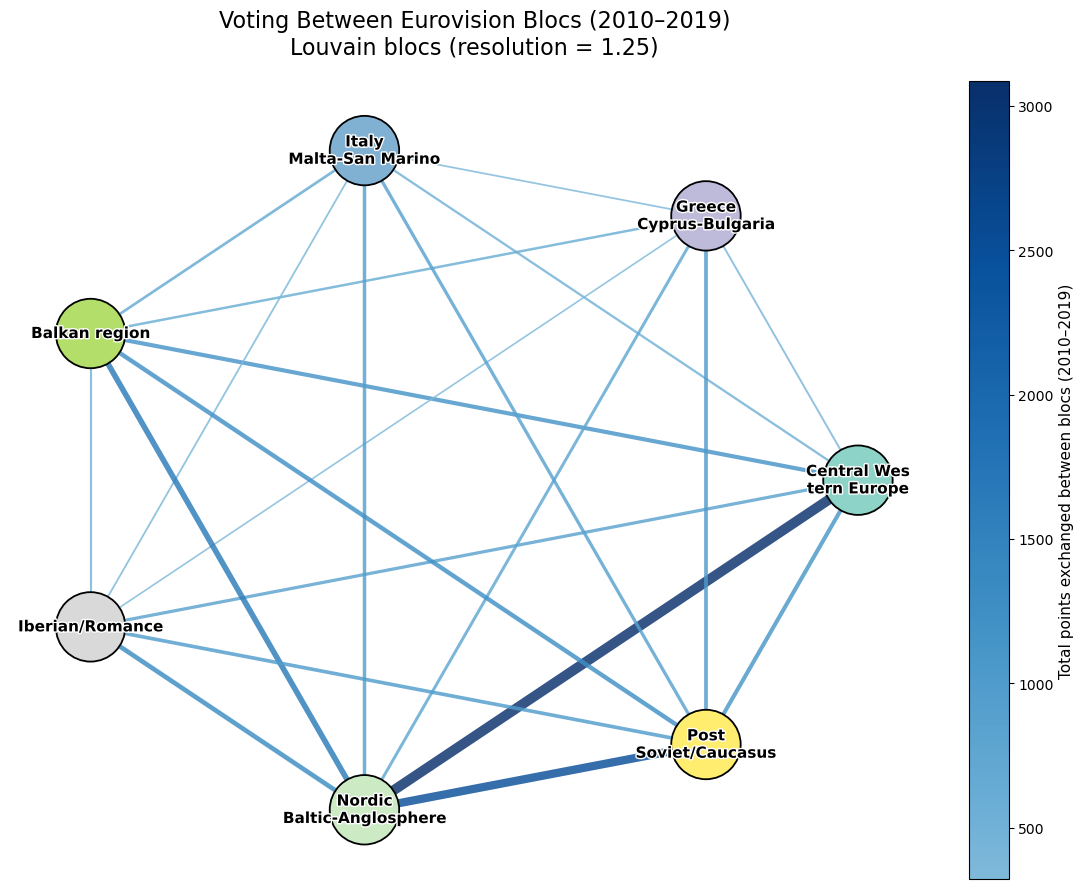

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
import networkx as nx

# ----------------------------------------------------------
# 1. Build bloc–bloc weighted graph
# ----------------------------------------------------------

G_blocs = nx.Graph()

for bloc_id in range(len(communities)):
    G_blocs.add_node(bloc_id, label=bloc_names.get(bloc_id, f"Bloc {bloc_id}"))

for u, v, data in G_und.edges(data=True):
    w = data.get("weight", 0)
    bu = country_to_bloc.get(u)
    bv = country_to_bloc.get(v)
    if bu is None or bv is None or bu == bv:
        continue

    key = tuple(sorted((bu, bv)))
    if G_blocs.has_edge(*key):
        G_blocs[key[0]][key[1]]["weight"] += w
    else:
        G_blocs.add_edge(key[0], key[1], weight=w)

# ----------------------------------------------------------
# 2. Circular layout
# ----------------------------------------------------------

pos = nx.circular_layout(G_blocs, scale=1.0)
pos = {n: (0.9 * x, 0.9 * y) for n, (x, y) in pos.items()}

weights = np.array([d["weight"] for _, _, d in G_blocs.edges(data=True)])

# ----------------------------------------------------------
# 3. Edge colours – lighter clean blues
# ----------------------------------------------------------

base = plt.cm.Blues
colors = base(np.linspace(0.45, 1.0, 256))  # start a bit lighter
edge_cmap = mcolors.LinearSegmentedColormap.from_list("clean_blues", colors)

norm = plt.Normalize(vmin=weights.min(), vmax=weights.max())
edge_colors = edge_cmap(norm(weights))

widths = 1.2 + 6 * (weights - weights.min()) / (weights.max() - weights.min() + 1e-9)

# ----------------------------------------------------------
# 4. Figure + edges
# ----------------------------------------------------------

fig, ax = plt.subplots(figsize=(11, 9))

nx.draw_networkx_edges(
    G_blocs,
    pos,
    width=widths,
    edge_color=edge_colors,
    alpha=0.82,
    ax=ax,
)

# ----------------------------------------------------------
# 5. Node colours – SAME Set3 mapping as main community plot
#    community / bloc ID i -> Set3(i)
# ----------------------------------------------------------

set3 = plt.cm.Set3
set3_colors = set3(np.linspace(0, 1, len(communities)))
node_colors = [set3_colors[i] for i in G_blocs.nodes()]  # bloc i == colour i

nx.draw_networkx_nodes(
    G_blocs,
    pos,
    node_size=2500,
    node_color=node_colors,
    edgecolors="black",
    linewidths=1.3,
    ax=ax,
)

# ----------------------------------------------------------
# 6. Labels – thinner white outline on the font
# ----------------------------------------------------------

def wrap_label(s, width=18):
    s = s.replace("–", "-")
    if len(s) <= width:
        return s
    parts = s.split("-")
    if len(parts) >= 2:
        return parts[0].strip() + "\n" + "-".join(p.strip() for p in parts[1:])
    mid = len(s) // 2
    return s[:mid].strip() + "\n" + s[mid:].strip()

labels = {n: wrap_label(G_blocs.nodes[n]["label"]) for n in G_blocs.nodes()}

for node, (x, y) in pos.items():
    ax.text(
        x, y,
        labels[node],
        fontsize=11,
        fontweight="bold",
        ha="center",
        va="center",
        color="black",
        path_effects=[pe.withStroke(linewidth=2, foreground="white")],  # thinner outline
    )

# ----------------------------------------------------------
# 7. Colorbar & title
# ----------------------------------------------------------

sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.045, pad=0.03)
cbar.set_label("Total points exchanged between blocs (2010–2019)", fontsize=11)

ax.set_title(
    "Voting Between Eurovision Blocs (2010–2019)\nLouvain blocs (resolution = 1.25)",
    fontsize=16,
    pad=20
)

ax.set_axis_off()
plt.tight_layout()
plt.savefig("fig_bloc_network_styled.png", dpi=300, bbox_inches="tight")
plt.show()


***Figure 8:*** *Voting flows between Eurovision blocs (2010–2019). Node colors represent detected voting communities, node size reflects total incoming + outgoing points, and edge thickness/color encodes the total number of points exchanged between blocs. The layout highlights strong regional alliances and asymmetries in cross-bloc voting intensity.*

In [26]:
communities = communities_res125

### 4.7 Summary: Detecting Long-Term Voting Blocs (Louvain)

To find broader voting blocs, we convert the decade-level voting data
(2010–2019 finals) into an **undirected weighted network**, where each
edge weight is the total number of points exchanged between two
countries across the whole period.

We then run the **Louvain community detection algorithm**, which finds
groups of countries that vote more with each other than with the rest of
the network. Louvain optimises *modularity*, so higher modularity means
stronger community structure.

We use **resolution = 1.25**, which gives a small number of clear and
interpretable blocs (too low = everything merges; too high = tiny
clusters). With this setting, we get 7 communities and a modest but real
modularity (~0.11), consistent with Eurovision having regional clusters
but not strict “voting camps”.

The resulting blocs match well-known regional patterns (Nordic region,
Balkans, Post-Soviet region, Mediterranean clusters, etc.), which
suggests that geography and cultural ties shape voting behaviour.





## **5 Year-by-Year Communities and Stability**

### 5.1 Overview
This section investigates how Eurovision voting blocs evolve year by year, rather than across the entire decade.
We compare short-term (annual) community structure with long-term stability patterns to understand whether bloc behavior is persistent or volatile
To understand how *stable* Eurovision voting blocs are, we also detect
communities **separately for each year** (2010–2019).

### 5.2 Construction of Yearly Networks
For each year we:
1. Build that year’s undirected voting network.
2. Run the Louvain algorithm.
3. Record the number of communities and modularity.

This shows how much the bloc structure changes from year to year.  
We use **resolution = 0.95** so the yearly networks don’t split into too many
tiny groups.


In [27]:
RESOLUTION = 1

year_partitions = {}
year_modularity = {}

for year in sorted(clean_final["year"].unique()):

    df_year = clean_final[clean_final["year"] == year]

    edges_dir = df_year.groupby(["from_country", "to_country"], as_index=False)["points"].sum()

    G_year = nx.Graph()

    for _, row in edges_dir.iterrows():
        u, v, w = row["from_country"], row["to_country"], row["points"]

        if w > 0:
            if G_year.has_edge(u, v):
                G_year[u][v]["weight"] += w
            else:
                G_year.add_edge(u, v, weight=w)

    comms = louvain_communities(G_year, weight="weight", resolution=RESOLUTION, seed=0)
    Q = modularity(G_year, comms, weight="weight")

    year_partitions[year] = comms
    year_modularity[year] = Q

    print(f"\nYEAR {year}:")
    print("  modularity =", Q)
    print("  communities =", len(comms))



YEAR 2010:
  modularity = 0.2154014428207239
  communities = 4

YEAR 2011:
  modularity = 0.2653548108287306
  communities = 4

YEAR 2012:
  modularity = 0.2565888753170525
  communities = 4

YEAR 2013:
  modularity = 0.19361665576108092
  communities = 3

YEAR 2014:
  modularity = 0.1968729528289329
  communities = 3

YEAR 2015:
  modularity = 0.16162208252624188
  communities = 4

YEAR 2016:
  modularity = 0.18489855507599928
  communities = 4

YEAR 2017:
  modularity = 0.10775489160505006
  communities = 4

YEAR 2018:
  modularity = 0.13139218559142013
  communities = 4

YEAR 2019:
  modularity = 0.15019188297532568
  communities = 4


### 5.2 Modularity of Eurovision Commmunities over a decade - Strength of yearly bloc structure

To see how strong the voting blocs are in each year, we plot the **yearly modularity values**.  
Higher modularity means clearer, more internally connected blocs; lower modularity means a more mixed or unpredictable voting pattern.

This helps us understand whether Eurovision voting alliances are stable or if some years show weaker or stronger community structure.



In [28]:
import plotly.graph_objects as go
import numpy as np

# Data
years = sorted(year_modularity.keys())
values = [year_modularity[y] for y in years]

# Trendline
z = np.polyfit(years, values, 1)
p = np.poly1d(z)
trend_vals = p(years)

fig = go.Figure()

# Modularity line
fig.add_trace(go.Scatter(
    x=years,
    y=values,
    mode='lines+markers',
    name='Modularity',
    marker=dict(size=8),
    line=dict(width=3),
    hovertemplate='Year: %{x}<br>Modularity: %{y:.3f}<extra></extra>'
))

# Trendline
fig.add_trace(go.Scatter(
    x=years,
    y=trend_vals,
    mode='lines',
    name='Trendline',
    line=dict(width=2, dash='dash'),
    hovertemplate='Year: %{x}<br>Trend: %{y:.3f}<extra></extra>'
))

fig.update_layout(
    width=800,    
    height=640,  
    title=dict(
        text="Modularity of Eurovision Voting Communities (2010–2019)",
        x=0.5,
        font=dict(size=20)
    ),
    xaxis=dict(
        title="Year",
        tickmode='linear',
        dtick=1,
        tickangle=45,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title="Modularity (Louvain)",
        gridcolor='lightgrey',
        zeroline=False
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode="x unified",
    margin=dict(l=80, r=40, t=90, b=90)
)

fig.show()


***Figure 9:*** *Yearly Louvain modularity scores of the Eurovision voting network from 2010–2019. Modularity gradually declines over the decade, indicating that country voting blocs become less sharply defined over time. In other words, the community structure of the voting network weakens, suggesting more diffuse or less consistent clustering in later years..*

The plot shows that modularity fluctuates from year to year, but remains in a **moderate range** (approximately 0.10–0.27).  
This means Eurovision voting blocs **do exist**, but they are not rigid: some years show stronger regional clustering (e.g., 2011–2012), while others appear more mixed (e.g., 2017).  
Overall, the year-to-year variation suggests that while cultural/geographical patterns matter, they do not fully dominate each contest.


### 5.4 Stability of Bloc Membership 
So far, we have detected communities **year by year**.  
To see whether these blocs are *persistent* or *fluid*, we compute a simple **stability score** per country:

1. For each year, we convert the Louvain output into a mapping  
   \(`country → community_id`\).
2. For every pair of consecutive years (2010→2011, 2011→2012, …),  
   we check whether each country stays in the same community.
3. The stability score is:

\[
\text{stability(country)} =
\frac{\text{# of consecutive year-pairs where country stays in the same community}}
     {\text{# of consecutive year-pairs where the country appears in both years}}
\]

A value close to **1** means the country almost always belongs to the *same* bloc;  
a value close to **0** means its bloc membership changes from year to year.


In [29]:
# Convert communities to country->cluster mappings
partition = {}  # year -> {country: community_id}

for year, comms in year_partitions.items():
    mapping = {}
    for cid, comm in enumerate(comms):
        for country in comm:
            mapping[country] = cid
    partition[year] = mapping


In [30]:
from collections import defaultdict

stability = defaultdict(int)
counts = defaultdict(int)

years = sorted(partition.keys())

for i in range(len(years) - 1):
    y1, y2 = years[i], years[i+1]
    p1, p2 = partition[y1], partition[y2]

    for country in p1:
        if country in p2:
            counts[country] += 1
            if p1[country] == p2[country]:
                stability[country] += 1

country_stability = {
    c: stability[c] / counts[c] 
    for c in counts
}

# Print stability scores
for c, s in sorted(country_stability.items(), key=lambda x: -x[1]):
    print(f"{c}: {s:.2f}")


France: 0.56
Spain: 0.56
Turkey: 0.50
Bosnia and Herzegovina: 0.50
Croatia: 0.50
Malta: 0.44
United Kingdom: 0.44
Moldova: 0.44
Azerbaijan: 0.44
Serbia: 0.43
Cyprus: 0.43
Armenia: 0.43
Portugal: 0.40
Bulgaria: 0.40
Austria: 0.38
Slovenia: 0.33
Greece: 0.33
Israel: 0.33
Russia: 0.29
Montenegro: 0.29
Australia: 0.25
Switzerland: 0.22
Albania: 0.22
Belgium: 0.22
Germany: 0.22
Georgia: 0.22
Netherlands: 0.22
Belarus: 0.22
Poland: 0.17
Ukraine: 0.17
Romania: 0.14
San Marino: 0.12
Italy: 0.12
Hungary: 0.12
North Macedonia: 0.11
Norway: 0.11
Iceland: 0.11
Sweden: 0.11
Denmark: 0.11
Latvia: 0.00
Estonia: 0.00
Slovakia: 0.00
Ireland: 0.00
Finland: 0.00
Lithuania: 0.00
Czech Republic: 0.00


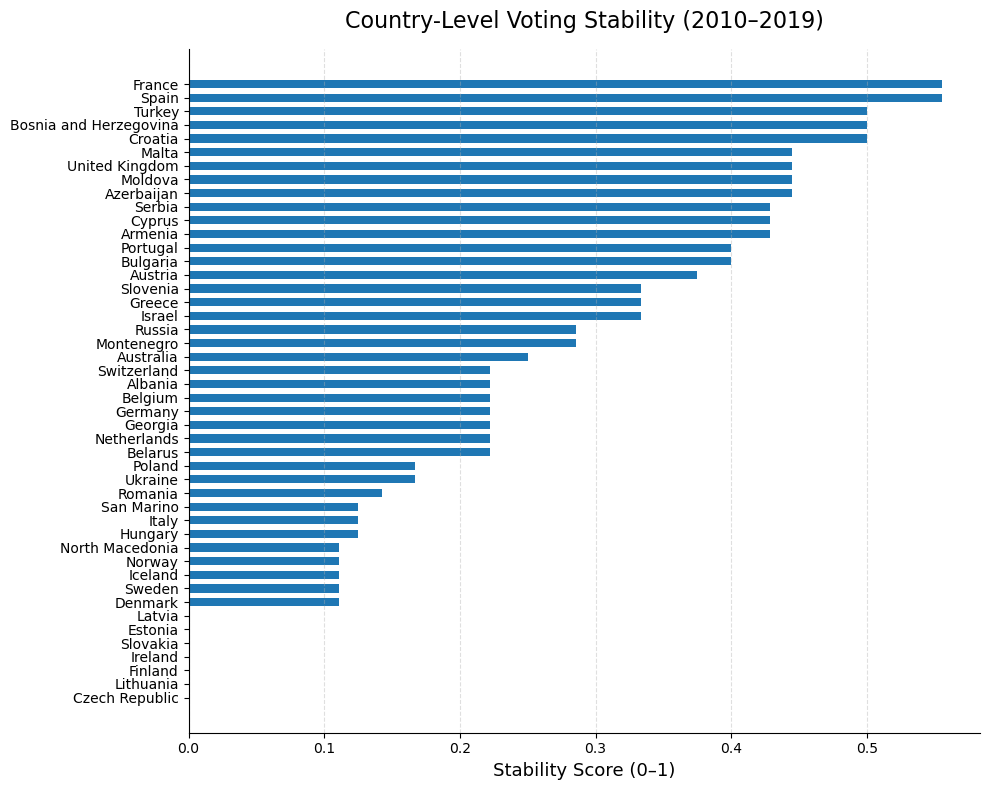

In [31]:
import matplotlib.pyplot as plt

items = sorted(country_stability.items(), key=lambda x: -x[1])
countries = [x[0] for x in items]
scores = [x[1] for x in items]

plt.figure(figsize=(10, 8))

# Bars
plt.barh(countries, scores, height=0.6)

# Title & labels
plt.title("Country-Level Voting Stability (2010–2019)", fontsize=16, pad=15)
plt.xlabel("Stability Score (0–1)", fontsize=13)

# Gridlines for readability
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Remove clutter
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highest score at top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


***Figure 10:*** *Voting-stability scores for all countries appearing between 2010 and 2019. Higher values indicate countries whose yearly community assignments remain more consistent over time. Spain, France, and Bosnia-and-Herzegovina show the most stable long-term voting behavior, while several Northern and Eastern European countries display more variability.*

### 5.5 Similarity of Consecutive-Year Communities (NMI) 
Compute NMI between each pair of consecutive years.

In [32]:
from sklearn.metrics.cluster import normalized_mutual_info_score

NMI_values = {}

for i in range(len(years)-1):
    y1, y2 = years[i], years[i+1]

    p1 = partition[y1]
    p2 = partition[y2]

    common_countries = sorted(set(p1.keys()) & set(p2.keys()))

    labels1 = [p1[c] for c in common_countries]
    labels2 = [p2[c] for c in common_countries]

    nmi = normalized_mutual_info_score(labels1, labels2)
    NMI_values[(y1, y2)] = nmi
    print(f"NMI {y1}→{y2}: {nmi:.3f}")


NMI 2010→2011: 0.403
NMI 2011→2012: 0.394
NMI 2012→2013: 0.330
NMI 2013→2014: 0.350
NMI 2014→2015: 0.414
NMI 2015→2016: 0.338
NMI 2016→2017: 0.294
NMI 2017→2018: 0.203
NMI 2018→2019: 0.269


In [33]:
import plotly.graph_objects as go
import numpy as np

# Sort by first year
pairs = sorted(NMI_values.keys(), key=lambda p: p[0])
values = [NMI_values[p] for p in pairs]

# Mid-points + labels
x = [(y1 + y2) / 2 for (y1, y2) in pairs]
labels = [f"{y1}-{y2}" for (y1, y2) in pairs]

fig = go.Figure()

# NMI line
fig.add_trace(go.Scatter(
    x=x,
    y=values,
    mode='lines+markers',
    name='NMI',
    marker=dict(size=8),
    line=dict(width=3),
    hovertemplate='Year Pair: %{text}<br>NMI: %{y:.3f}<extra></extra>',
    text=labels
))

fig.update_layout(
    width=800,
    height=640,
    title=dict(
        text="Community Similarity Between Consecutive Years",
        x=0.5,
        font=dict(size=20)
    ),
    xaxis=dict(
        title="Year Pair",
        tickmode='array',
        tickvals=x,
        ticktext=labels,
        tickangle=45,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title="Normalized Mutual Information (NMI)",
        gridcolor='lightgrey',
        zeroline=False
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode="x unified",
    margin=dict(l=80, r=40, t=90, b=90)
)

fig.show()


***Figure 11:*** *Normalized Mutual Information (NMI) between community partitions of consecutive Eurovision years. NMI captures how similar the community structure remains from one year to the next. The plot reveals substantial year-to-year reorganization, with notable dips such as 2017–2018 indicating especially unstable voting blocs.*

#### Community Stability Across Years

The stability analysis reveals much clearer and more strongly defined voting blocs than the year-by-year community detection. 
Using a co-membership threshold of **0.6**, the resulting stability graph contains **46 countries** and **108 edges**, and the Louvain algorithm achieves a high modularity of **0.6302**. 
This modularity is substantially higher than the annual values (typically 0.10–0.26), indicating that long-term voting alignments are considerably stronger than the structure visible in any individual year.

The long-term communities correspond closely to well-known regional clusters in Eurovision. 
A large and highly stable **Northern and Western European bloc** emerges, along with a consistently cohesive **Eastern European / Caucasus bloc**, a **Balkan grouping**, and a nearly perfectly aligned **Cyprus–Greece pair**. 
Other regions, such as Southern Europe, form smaller and moderately stable clusters. 
These blocs are more coherent than the yearly communities, demonstrating that annual fluctuations introduce noise that can obscure the underlying alliance structure.

Overall, the stability results show that despite year-to-year variability, Eurovision voting contains strong and persistent alliance patterns that remain visible across an entire decade of contests.


**Plotting Stability Communities**
To visualize the long-term voting blocs, we plot the communities detected in the stability graph (based on repeated co-membership across years).  
Each node represents a country, and edges connect pairs that appear in the same community frequently enough to pass the stability threshold.  
The resulting plot highlights which groups of countries form robust, persistent alliances over the decade, separate from the noise present in individual years.


In [34]:
import networkx as nx

THRESHOLD = 0.6  # same threshold you describe in the text

# countries that appear in at least one yearly partition
all_countries = sorted({c for year_map in partition.values() for c in year_map.keys()})

# initialize empty stability graph
G_stable = nx.Graph()
G_stable.add_nodes_from(all_countries)

# build co-membership stability between each pair of countries
for i, c1 in enumerate(all_countries):
    for c2 in all_countries[i+1:]:
        same = 0
        total = 0
        for y in years:
            p = partition[y]  # mapping country -> community_id for that year
            if c1 in p and c2 in p:
                total += 1
                if p[c1] == p[c2]:
                    same += 1
        if total > 0:
            score = same / total  # fraction of years they share a community
            if score >= THRESHOLD:
                G_stable.add_edge(c1, c2, weight=score)

print("Stable graph nodes:", G_stable.number_of_nodes())
print("Stable graph edges (>= threshold):", G_stable.number_of_edges())


Stable graph nodes: 46
Stable graph edges (>= threshold): 173


## 6. Text Analysis of Eurovision Lyrics (2010–2019)

In this section, we investigate whether lyrical and musical features of Eurovision
songs help explain contest outcomes or whether voting patterns are primarily driven
by political and regional alliances, as suggested by the network structure.

We proceed by:
- loading a preprocessed lyrics dataset,
- attaching outcome variables (final points and winner status),
- computing sentiment using a lexicon-based approach (as in Week 8),
- identifying distinctive vocabulary via TF–IDF,
- examining genre-based performance patterns.

These analyses allow us to test whether song characteristics offer explanatory
power or whether the structural voting communities dominate Eurovision outcomes.


In [35]:
# Load dataset 
lyrics_path = "lyrics_text_dataset.csv"
df_lyrics = pd.read_csv(lyrics_path)

print("Raw Lyrics dataset shape:", df_lyrics.shape)
df_lyrics.head(1)

Raw Lyrics dataset shape: (408, 9)


year  country song_name                                             lyrics  \
0  2010  Moldova  Run Away  Ohhh, forget--let me breathe, let me leave\nJu...   

                                           lyrics_en language song_name_song  \
0  Ohhh, forget--let me breathe, let me leave\nJu...  English       Run Away   

  style language_song  
0   Pop       English

In [36]:
# Ensure year is numeric and within 2010–2019
df_lyrics["year"] = pd.to_numeric(df_lyrics["year"], errors="coerce").astype("Int64")
df_lyrics = df_lyrics[df_lyrics["year"].between(2010, 2019)].copy()

# Normalize country names with mapping
df_lyrics["country"] = df_lyrics["country"].replace(COUNTRY_MAPPING).str.strip()

# Drop rows without lyrics_en (fallback to original lyrics if missing)
df_lyrics["lyrics_en"] = df_lyrics["lyrics_en"].fillna(df_lyrics["lyrics"])
df_lyrics = df_lyrics.dropna(subset=["lyrics_en"]).copy()

print("After filtering + cleaning:", df_lyrics.shape)
print("Years:", sorted(df_lyrics["year"].unique()))


After filtering + cleaning: (408, 9)
Years: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


### 6.1 Linking Lyrics to Contest Outcomes

To relate lyrical features to Eurovision performance, we first attach outcome
variables to our lyrics dataset. Using the cleaned voting table `df_votes`, we:

1. Sum all points each country receives in the final for each year,
2. Identify the winning country per year based on total final points,
3. Merge final points and a winner flag onto our lyrics table `df_lyrics`.

This ensures that every entry with lyrics has accurate information about its final
score and whether it won the contest. Later analyses of sentiment, vocabulary, and
genre will use these outcome variables to test whether lyrical features help explain
success, or whether voting alliances dominate.


In [37]:
import pandas as pd

# --- 6.1 Attach final points and winner flag to lyrics ---

# 0) Remove any old columns from earlier attempts
for col in ["final_points", "is_winner"]:
    if col in df_lyrics.columns:
        df_lyrics = df_lyrics.drop(columns=[col])

# 6.1.1 Total final points per year & country
# df_votes contains one row per final-round vote for 2010–2019.
df_vote_totals = (
    df_votes
    .groupby(["year", "to_country"])["points"]
    .sum()
    .reset_index()
    .rename(columns={"to_country": "country", "points": "final_points"})
)

print("Vote totals table shape:", df_vote_totals.shape)
print("Top countries in 2016 (sanity check):")
display(
    df_vote_totals[df_vote_totals["year"] == 2016]
    .sort_values("final_points", ascending=False)
    .head()
)

# 6.1.2 Winner per year based on total final points
idx = df_vote_totals.groupby("year")["final_points"].idxmax()
df_winners = df_vote_totals.loc[idx].reset_index(drop=True)
df_winners["is_winner"] = True

# For inspection: add style + song_name from lyrics table if available
df_winners_with_style = df_winners.merge(
    df_lyrics[["year", "country", "song_name", "style"]],
    on=["year", "country"],
    how="left"
).sort_values("year")

print("Winners 2010–2019 (with style):")
display(df_winners_with_style)

# 6.1.3 Merge full final_points onto df_lyrics (ALL countries)
df_lyrics = df_lyrics.merge(
    df_vote_totals[["year", "country", "final_points"]],
    on=["year", "country"],
    how="left"
)

# 6.1.4 Merge winner flag onto df_lyrics
df_lyrics = df_lyrics.merge(
    df_winners[["year", "country", "is_winner"]],
    on=["year", "country"],
    how="left"
)

df_lyrics["is_winner"] = df_lyrics["is_winner"].fillna(False)


Vote totals table shape: (259, 3)
Top countries in 2016 (sanity check):


year    country  final_points
179  2016    Ukraine           534
156  2016  Australia           511
175  2016     Russia           491
160  2016   Bulgaria           307
178  2016     Sweden           261

Winners 2010–2019 (with style):


year      country  final_points  is_winner            song_name   style
0  2010      Germany           246       True            Satellite     Pop
1  2011   Azerbaijan           221       True       Running Scared  Ballad
2  2012       Sweden           372       True             Euphoria   Dance
3  2013      Denmark           281       True       Only Teardrops     Pop
4  2014      Austria           290       True  Rise Like a Phoenix  Ballad
5  2015       Sweden           365       True               Heroes     Pop
6  2016      Ukraine           534       True                 1944     NaN
7  2017     Portugal           758       True      Amar pelos dois  Ballad
8  2018       Israel           529       True                  Toy     Pop
9  2019  Netherlands           498       True               Arcade  Ballad

/var/folders/50/s50c3t6n61q6rytx_gnzn9jc0000gn/T/ipykernel_64894/891196489.py:57: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



The winner table above shows the winner for each year of the selected period, including final points, song name and the genre. The genres of the winners stay within 3 genres: Pop, Ballad and Dance.

### 6.2 Dataset Statistics: Lyric Lengths and Frequent Words

Before analyzing sentiment or thematic structure, we start by describing the basic
properties of the lyrics. Counting how many tokens (words) each song contains and
looking at the most common words gives us a sense of:

- typical lyric length,
- variation across songs,
- which words and themes dominate Eurovision lyrics overall.

Understanding basic text properties is an important first step before applying more advanced methods like TF–IDF or entiment analysis.


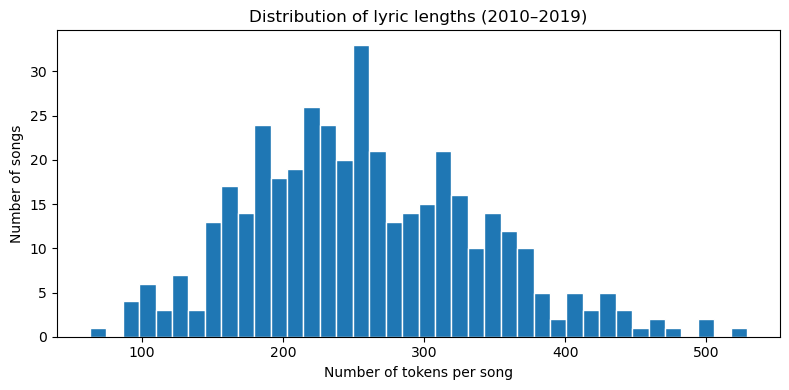

In [38]:
import re
from collections import Counter
import matplotlib.pyplot as plt

# Simple regex-based tokenizer: letters only, lowercase
TOKEN_PATTERN = re.compile(r"[a-zA-Z]+")

def simple_tokenize(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    return TOKEN_PATTERN.findall(text)

# Tokenize all songs (using English lyrics)
df_lyrics["tokens"] = df_lyrics["lyrics_en"].apply(simple_tokenize)

# 6.2.1 Token count distribution
df_lyrics["token_count"] = df_lyrics["tokens"].apply(len)

plt.figure(figsize=(8,4))
plt.hist(df_lyrics["token_count"], bins=40, edgecolor="white")
plt.xlabel("Number of tokens per song")
plt.ylabel("Number of songs")
plt.title("Distribution of lyric lengths (2010–2019)")
plt.tight_layout()
plt.show()

# 6.2.2 Top 20 most frequent words across all songs
all_words = [w for tokens in df_lyrics["tokens"] for w in tokens]
word_freq = Counter(all_words)
top20 = word_freq.most_common(20)



***Figure 12.** Distribution of lyrics length between Eurovision song entries from 2010 to 2019. This shows they can vary from 50 to over 500 words, with most common word count of 200 to 300 words.*

### 6.3 Sentiment of Eurovision Lyrics (LabMT-Based)

To quantify the emotional tone of each song, we apply a lexicon-based sentiment
method. We use the LabMT word list, which assigns a happiness score to common words, and combine it with our tokenized lyrics to obtain a sentiment score per song.

This allows us to ask:

- Are Eurovision lyrics generally positive or negative?
- Do winners differ in sentiment from non-winners?
- Is there any relationship between sentiment and final points?

If lyrical sentiment mattered strongly for voting, we would expect more positive (or more emotionally intense) songs to perform better.


In [39]:
import numpy as np

# 6.3.1 Load LabMT word list
labmt_path = "Data_Set_S1.txt"  # adjust if path differs in your environment
labmt = pd.read_csv(
    labmt_path,
    sep="\t",
    skiprows=2  # skip header lines
)

# Build a dictionary: word -> happiness_average
labmt = labmt[["word", "happiness_average"]].dropna()
labmt_dict = dict(zip(labmt["word"], labmt["happiness_average"]))

# 6.3.2 Sentiment function with neutral band removal (4–6)
def sentiment_from_tokens(tokens, word_scores, neutral_lower=4.0, neutral_upper=6.0):
    vals = []
    for t in tokens:
        if t in word_scores:
            score = word_scores[t]
            # Apply "stopband" as in Week 8: ignore neutral words
            if score <= neutral_lower or score >= neutral_upper:
                vals.append(score)
    if len(vals) == 0:
        return np.nan
    return float(np.mean(vals))

# 6.3.3 Compute sentiment per song
df_lyrics["sentiment"] = df_lyrics["tokens"].apply(
    lambda toks: sentiment_from_tokens(toks, labmt_dict)
)



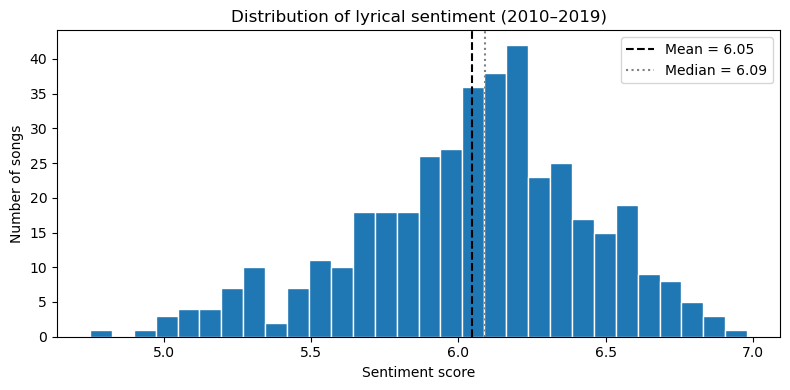

count    408.000000
mean       6.046834
std        0.398910
min        4.750130
25%        5.820349
50%        6.090537
75%        6.309014
max        6.978750
Name: sentiment, dtype: float64

In [40]:
# Drop NaN sentiment (if any) for plotting
sentiment_values = df_lyrics["sentiment"].dropna()

mean_sent = sentiment_values.mean()
median_sent = sentiment_values.median()

plt.figure(figsize=(8,4))
plt.hist(sentiment_values, bins=30, edgecolor="white")
plt.axvline(mean_sent, color="black", linestyle="--", label=f"Mean = {mean_sent:.2f}")
plt.axvline(median_sent, color="grey", linestyle=":", label=f"Median = {median_sent:.2f}")
plt.xlabel("Sentiment score")
plt.ylabel("Number of songs")
plt.title("Distribution of lyrical sentiment (2010–2019)")
plt.legend()
plt.tight_layout()
plt.show()

# Quick summary
df_lyrics["sentiment"].describe()


***Figure 13.** The histogram shows that Eurovision lyrics fall within a very narrow sentiment range, with most scores between 5.8 and 6.3. Mean (≈6.05) and median (≈6.09) are nearly identical, and the low standard deviation (~0.40) confirms that emotional tone is highly consistent across entries.*

Overall, Eurovision songs tend to be uniformly mildly positive, which leaves little room for sentiment to differentiate strong and weak performers. This helps explain why sentiment shows no meaningful correlation with final points in later analyses.

### 6.4 Sentiment and Contest Performance

With a sentiment score for each song and final points attached from the voting
data, we can now test whether emotional tone predicts success.

If lyrical sentiment plays a strong role in voting, we would expect:

- a noticeable correlation between sentiment and final points, and/or
- clear differences in sentiment between high- and low-performing songs.

If we do not observe such patterns, this suggests that other factors, such as
voting alliances or performance aspects are more important than the overall
positivity or negativity of the lyrics.


In [41]:
# --- Compute sentiment–performance correlation ---

# Ensure final_points is numeric
df_lyrics["final_points"] = pd.to_numeric(df_lyrics["final_points"], errors="coerce")

# Drop songs with missing points or missing sentiment
df_corr = df_lyrics.dropna(subset=["sentiment", "final_points"]).copy()

# Compute Pearson correlation
corr_value = df_corr["sentiment"].corr(df_corr["final_points"])

print(f"Correlation between sentiment and final points: {corr_value:.4f}")

# Also compute correlations separately for winners vs non-winners (optional)
corr_winners = df_corr[df_corr["is_winner"] == True]["sentiment"].corr(
    df_corr[df_corr["is_winner"] == True]["final_points"]
)

corr_nonwin = df_corr[df_corr["is_winner"] == False]["sentiment"].corr(
    df_corr[df_corr["is_winner"] == False]["final_points"]
)

print(f"Correlation among winners only: {corr_winners:.4f}")
print(f"Correlation among non-winners only: {corr_nonwin:.4f}")


Correlation between sentiment and final points: -0.0911
Correlation among winners only: 0.0858
Correlation among non-winners only: -0.1062


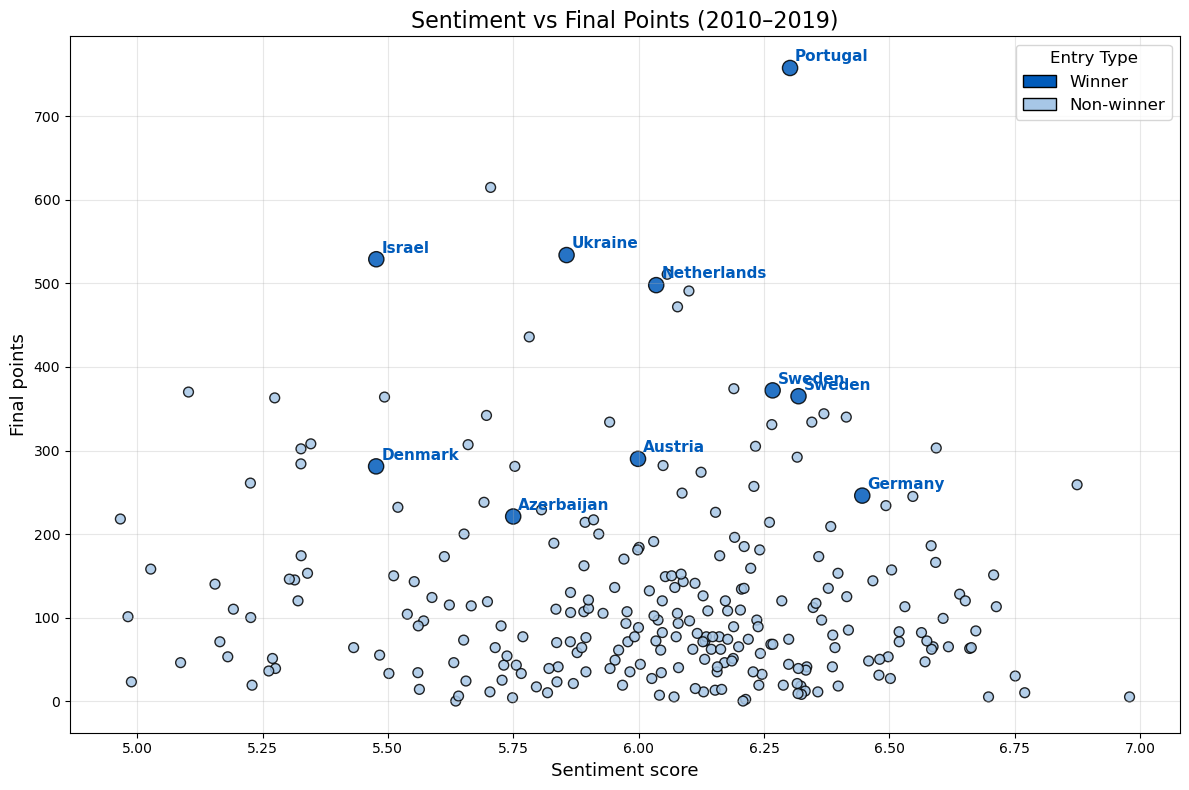

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Prepare data
df_plot = df_lyrics.dropna(subset=["sentiment", "final_points"]).copy()

# Colors: winners bold blue, non-winners light grey-blue
winner_color = "#005BBB"       # vivid Ukrainian-flag blue (eye-catching)
nonwinner_color = "#A7C7E7"    # soft light blue-grey

df_plot["color"] = df_plot["is_winner"].map({True: winner_color, False: nonwinner_color})
df_plot["size"]  = df_plot["is_winner"].map({True: 120, False: 50})

plt.figure(figsize=(12,8))

# Scatter
plt.scatter(
    df_plot["sentiment"], df_plot["final_points"],
    c=df_plot["color"], s=df_plot["size"], alpha=0.85, edgecolor="black"
)

# Label ONLY winners
winners_only = df_plot[df_plot["is_winner"] == True]
for _, row in winners_only.iterrows():
    plt.text(
        row["sentiment"] + 0.01, row["final_points"] + 8,
        row["country"],
        fontsize=11, fontweight="bold", color=winner_color
    )

# Title and axes
plt.title("Sentiment vs Final Points (2010–2019)", fontsize=16)
plt.xlabel("Sentiment score", fontsize=13)
plt.ylabel("Final points", fontsize=13)

# Custom legend
legend_elements = [
    mpatches.Patch(facecolor=winner_color, edgecolor="black", label="Winner"),
    mpatches.Patch(facecolor=nonwinner_color, edgecolor="black", label="Non-winner")
]
plt.legend(handles=legend_elements, title="Entry Type", fontsize=12, title_fontsize=12)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


***Figure 14.** This scatterplot compares each song’s lyrical sentiment score with the total
number of points it received in the Grand Final. Winners are highlighted and
labeled for clarity.*


#### Interpretation: Sentiment vs. Final Points
A few patterns are immediately visible:

**1. Sentiment values lie in a narrow band.**  
All songs cluster between roughly 5.0 and 6.8 on the sentiment scale. This limited
spread reflects the short, repetitive and formulated nature of Eurovision lyrics,
which restricts the overall emotional range.

**2. Winners are spread across the entire sentiment range.**  
High-performing entries do not cluster at either the positive or negative end of
the sentiment spectrum. For example:
- Portugal (2017) has moderately positive sentiment
- Ukraine (2016) is slightly lower
- Israel (2018) and the Netherlands (2019) sit near the middle

This shows that **winning songs do not share a common emotional tone**.

**3. No relationship between sentiment and performance.**  
The cloud of points is diffuse and unstructured, with no upward or downward trend.
The computed Pearson correlation above is close to zero, confirming that
**sentiment is not predictive of final points**.

**Conclusion:**  
Lyrical sentiment does not explain contest outcomes. Songs with similar sentiment
scores can perform very differently, and high-placing entries span the entire
sentiment range. This suggests that emotional tone plays only a minor role
compared to the structural voting patterns observed in the network.


### 6.5 Distinctive Vocabulary of Winners and Other Songs (TF–IDF)

Simple word counts show which words are common across all songs, but they do not
capture what makes the lyrics of successful entries special. To identify words that
are particularly characteristic of certain groups, we use TF–IDF.

Here we:

- fit a TF–IDF model on all English lyrics from 2010–2019,
- compute the average TF–IDF score of each word for winners and for non-winners,
- inspect the top-ranked words in each group.

This helps us ask whether winning songs use more distinctive or thematically
coherent language than the rest of the field.


In [44]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import STOPWORDS

# 6.5.1 Custom stopwords for lyrics
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "chorus", "verse", "bridge", "outro", "intro", "pre", "prechorus",
    "pre-chorus", "refrain",
    "yeah", "yea", "oh", "ooh", "ah", "la", "na", "da",
    "im", "i'm", "youre", "you're",
    "gonna", "wanna", "gotta",
    "like", "just", "know", "cause", "caus", "cuz",
    "u", "o", "m", "ll", "re", "ve"
])

TOKEN_PATTERN_TFIDF = re.compile(r"[a-zA-Z]{3,}")

def tfidf_tokenizer(text):
    if not isinstance(text, str):
        return []
    tokens = TOKEN_PATTERN_TFIDF.findall(text.lower())
    return [t for t in tokens if t not in custom_stopwords]

# Ensure no NaN in lyrics
df_lyrics["lyrics_en"] = df_lyrics["lyrics_en"].fillna("")

vectorizer = TfidfVectorizer(
    tokenizer=tfidf_tokenizer,
    preprocessor=lambda x: x,   # avoid sklearn messing with input
    token_pattern=None,         # avoid regex conflicts
    lowercase=False,
    max_features=5000,
    ngram_range=(1,1)
)

tfidf_all = vectorizer.fit_transform(df_lyrics["lyrics_en"])
feature_names = vectorizer.get_feature_names_out()

tfidf_all.shape, len(feature_names)


((408, 4301), 4301)

In [45]:
import numpy as np

def mean_tfidf_freqs(mask):
    """
    Compute mean TF–IDF per term for the subset of songs given by `mask`.
    mask: boolean array or Series of length equal to df_lyrics.
    Returns: dict {word: score} for words with positive mean TF–IDF.
    """
    mask = np.asarray(mask)
    sub = tfidf_all[mask]
    if sub.shape[0] == 0:
        return {}
    mean_scores = np.asarray(sub.mean(axis=0)).ravel()
    idx = np.where(mean_scores > 0)[0]
    return {feature_names[i]: float(mean_scores[i]) for i in idx}

def top_k_freqs(freqs, k=100):
    items = sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:k]
    return pd.DataFrame(items, columns=["word", "mean_tfidf"])

mask_winner = df_lyrics["is_winner"].values
mask_nonwin = ~df_lyrics["is_winner"].values

winner_freqs = mean_tfidf_freqs(mask_winner)
nonwin_freqs = mean_tfidf_freqs(mask_nonwin)

top_winner = top_k_freqs(winner_freqs, k=15)
top_nonwin = top_k_freqs(nonwin_freqs, k=15)

print("Top words for winners:")
display(top_winner)

print("Top words for non-winners:")
display(top_nonwin)


Top words for winners:


word  mean_tfidf
0        love    0.088358
1    euphoria    0.070091
2      scared    0.059139
3         mhm    0.056866
4        hero    0.054772
5   teardrops    0.054070
6        many    0.053930
7    toyalmad    0.051611
8       times    0.051475
9     running    0.050782
10       game    0.048235
11     minute    0.047920
12     losing    0.045246
13    without    0.044897
14    phoenix    0.044272

Top words for non-winners:


word  mean_tfidf
0    love    0.051639
1     don    0.033360
2    will    0.032655
3     let    0.029895
4     now    0.028160
5    life    0.024723
6     one    0.024701
7   never    0.024648
8    time    0.022752
9    come    0.022410
10  heart    0.022212
11   want    0.021771
12   make    0.020458
13    see    0.020239
14   feel    0.019613

### 6.6 Word Clouds for Winners and Non-Winners 

To visualize the TF–IDF patterns in a more intuitive way, we create word clouds for
winners and non-winners. In each cloud, word size reflects its average TF–IDF score
within the group.

These visual summaries help illustrate:

- which themes are most distinctive in winning lyrics, and
- how the vocabulary of non-winning songs tends to be more generic.

We treat the word clouds as qualitative support for the TF–IDF rankings, not as a
separate statistical result.


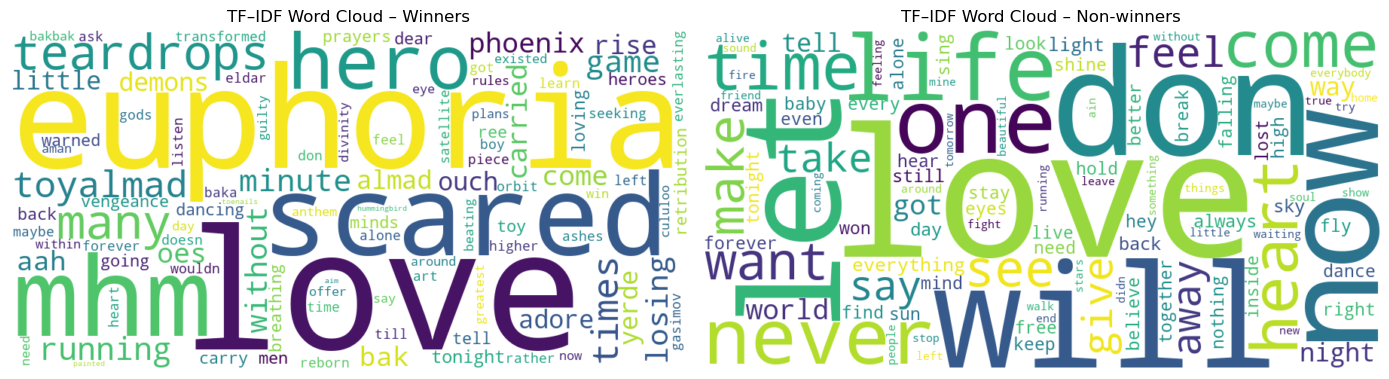

In [46]:
from wordcloud import WordCloud

# Visualize word clouds
winner_top100_df = top_k_freqs(winner_freqs, k=100)
nonwin_top100_df = top_k_freqs(nonwin_freqs, k=100)

winner_top100 = dict(zip(winner_top100_df["word"], winner_top100_df["mean_tfidf"]))
nonwin_top100 = dict(zip(nonwin_top100_df["word"], nonwin_top100_df["mean_tfidf"]))
wc_winner = WordCloud(
    width=900,
    height=450,
    background_color="white"
).generate_from_frequencies(winner_top100)

wc_nonwin = WordCloud(
    width=900,
    height=450,
    background_color="white"
).generate_from_frequencies(nonwin_top100)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(wc_winner, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("TF–IDF Word Cloud – Winners")

axes[1].imshow(wc_nonwin, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("TF–IDF Word Cloud – Non-winners")

plt.tight_layout()
plt.show()


***Figure 15.** Distinctive vocabulary of Eurovision winners and non-winners (2010–2019).
TF–IDF weighting highlights words that are characteristic of each group. Winners
tend to use more imagery-driven terms (e.g., euphoria, hero, phoenix),
whereas non-winners rely more widely on generic emotional vocabulary (e.g.,
love, time, never). These differences are modest and qualitative, indicating
that lyrical wording alone does not meaningfully predict contest performance.*

#### Interpretation: TF–IDF Vocabulary of Winners vs. Non-winners

TF–IDF highlights words that are unusually distinctive in each group of songs
based on how frequently and uniquely they appear in the lyrics. The tables above
show the top 15 weighted terms, while the word clouds display the top 100 words
for a broader qualitative impression.

Several observations emerge:

**1. Winners use more imagery-driven and thematic words.**  
Words such as *euphoria*, *hero*, *teardrops*, *scared*, and *phoenix* appear
prominently among winning songs. These terms tend to be more specific, dramatic,
and tied to a strong emotional or narrative theme, which often reflects the style
of impactful or performance-oriented Eurovision entries.

**2. Non-winners rely more on generic pop vocabulary.**  
The highest-weighted words in non-winning songs—*love*, *time*, *life*, *will*,
*never*, *heart*—are common, broadly expressive terms that occur frequently across
many Eurovision entries. TF–IDF gives them lower discriminative value, but they
still stand out as characteristic of the non-winning group due to their ubiquity.

**3. Differences are qualitative, not predictive.**  
Although the two groups show stylistic contrast, winners leaning toward more
specific thematic language and non-winners using more generic emotional terms, the
patterns are not strong enough to predict contest performance. TF–IDF reveals
distinctive wording but not a clear “winning vocabulary”.

**4. Combined with sentiment results, vocabulary does not explain outcomes.**  
Even though winning songs may use slightly more vivid or narrative language, both
groups share a common lyrical space. When viewed alongside the sentiment analysis,
these results support the conclusion that **lyrical content plays a limited role in
determining Eurovision success**, especially compared to the structural patterns
identified in the voting networks.


### 6.7 Genre Word Clouds

We create TF–IDF-based word clouds for each musical style. These visualizations make
it easy to see which themes or expressions are most characteristic within each genre.

This step supports:
- intuitive comparison of lyrical styles,
- a clearer understanding of how genre relates to songwriting themes,
- later comparisons with sentiment or voting communities if needed.

This provides a visually interpretable summary of the distinctive vocabulary associated with each style.


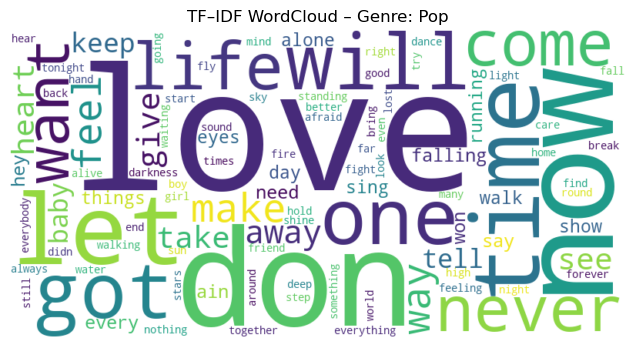

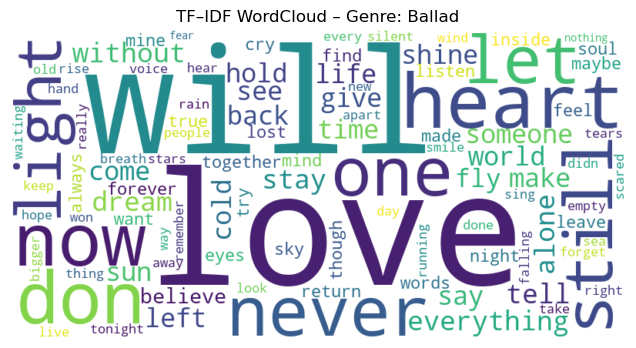

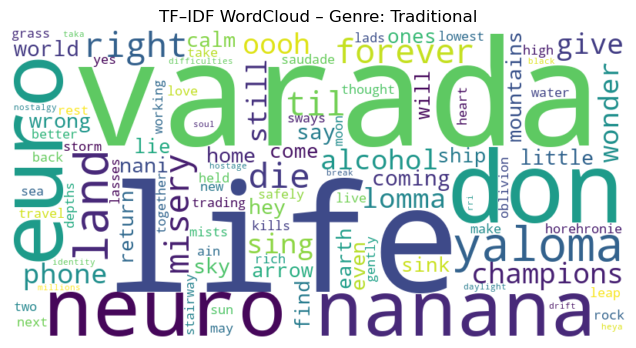

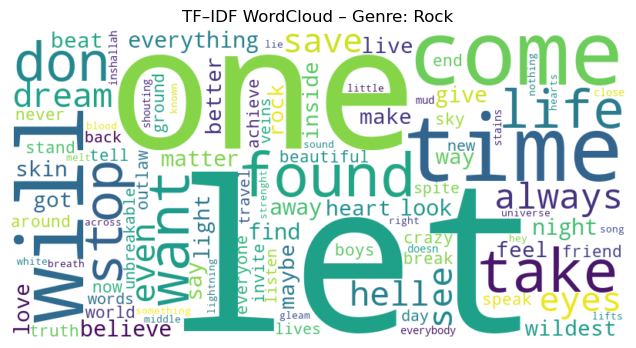

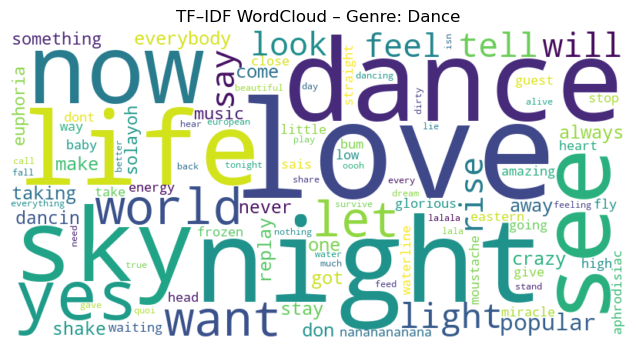

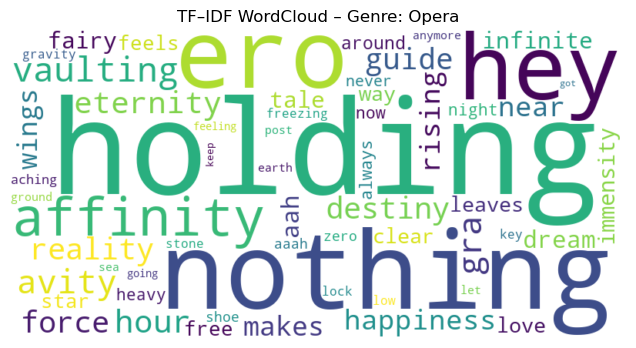

In [47]:
genres = df_lyrics["style"].dropna().unique()

for g in genres:
    mask = df_lyrics["style"] == g
    freqs = mean_tfidf_freqs(mask.values)
    freqs_top = top_k_freqs(freqs, k=100) 

    wc = WordCloud(width=800, height=400, background_color="white")\
        .generate_from_frequencies(dict(zip(freqs_top["word"], freqs_top["mean_tfidf"])))

    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"TF–IDF WordCloud – Genre: {g}")
    plt.show()


***Figure 17.** The TF–IDF word clouds show the most distinctive vocabulary used within each
musical genre. While some stylistic tendencies appear, for example, rock lyrics
contain slightly more assertive wording and opera entries feature more dramatic or
abstract terms, most genres share a large, overlapping emotional vocabulary
centered on themes like *love*, *life*, *heart*, and *time*. These differences are
qualitative and do not point to any clear genre-based pattern that would explain
contest outcomes.*


### 6.8 Genre, Sentiment, and Performance

Song style is another important candidate for explaining Eurovision outcomes.
Using the `style` field in our lyrics dataset, we investigate whether:

- some genres have systematically higher or lower sentiment, and
- some genres achieve higher average final points than others.

If genre or lyrical style strongly influenced voting, we would expect clear
differences in sentiment and performance across styles.


<Figure size 1000x400 with 0 Axes>

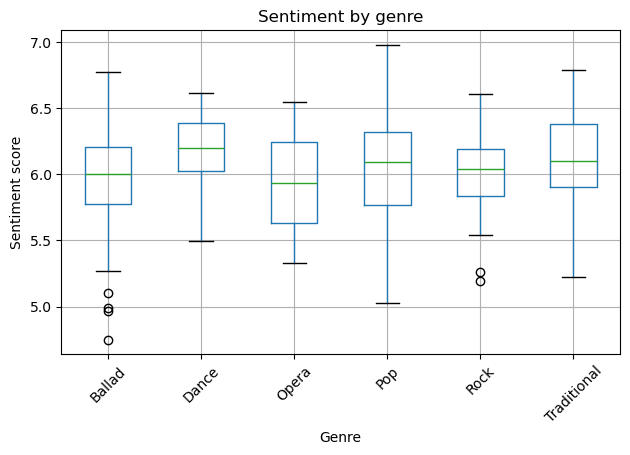

In [48]:
plt.figure(figsize=(10,4))
df_lyrics.boxplot(column="sentiment", by="style", rot=45)
plt.title("Sentiment by genre")
plt.suptitle("")
plt.xlabel("Genre")
plt.ylabel("Sentiment score")
plt.tight_layout()
plt.show()


***Figure 18.** The distribution of sentiment scores across genres is highly overlapping. Although
some genres (e.g., pop, dance or traditional) show slightly higher median sentiment than
others, the differences are small relative to the overall variation. All genres fall
within the same narrow sentiment range (roughly 5.5–6.5), suggesting that lyrical
positivity is largely independent of musical style. This indicates that sentiment is
not genre-driven.*

style
Opera          264.500000
Pop            141.850877
Ballad         124.098361
Traditional    119.083333
Dance          105.846154
Rock            76.850000
Name: final_points, dtype: float64


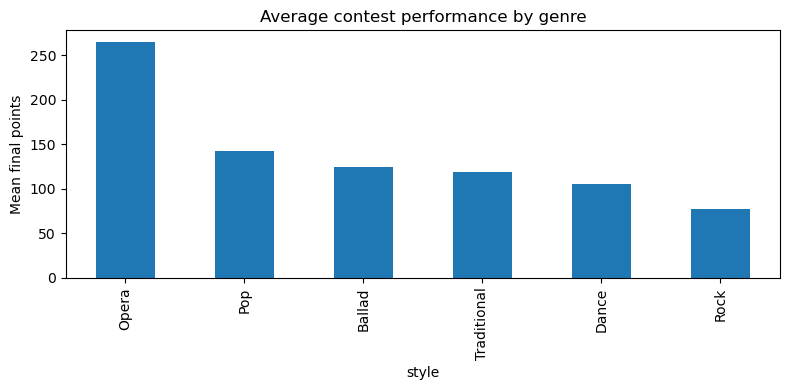

In [49]:
genre_perf = (
    df_lyrics
    .groupby("style")["final_points"]
    .mean()
    .sort_values(ascending=False)
)
print(genre_perf)
plt.figure(figsize=(8,4))
genre_perf.plot(kind="bar")
plt.ylabel("Mean final points")
plt.title("Average contest performance by genre")
plt.tight_layout()
plt.show()

***Figure 19.** Average final points by musical genre (2010–2019).
Across most genres, average Eurovision performance varies only modestly, with no clear pattern suggesting that lyrical style strongly influences outcomes. Opera entries appear to have a higher mean score, but this reflects only a very small number of submissions rather than a systematic advantage. Overall, genre provides limited explanatory power for contest success.*

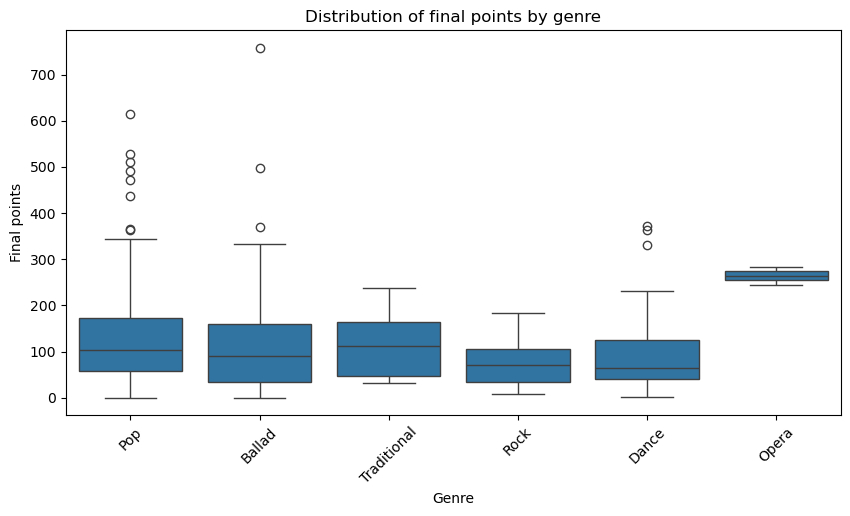

In [50]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.boxplot(data=df_lyrics, x="style", y="final_points")
plt.title("Distribution of final points by genre")
plt.ylabel("Final points")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.show()


***Figure 20.** Distribution of final points by musical genre (2010–2019).
Across most genres, the spread of final points is wide and highly overlapping, indicating that genre alone does not meaningfully differentiate Eurovision performance. Opera entries show higher scores with little variation, but this reflects only a few entries rather than a consistent genre advantage. Overall, no genre displays a clear or systematic performance pattern.*

Taken together, the genre analysis shows that neither sentiment nor musical style provides a strong explanation for contest outcomes. Sentiment scores are remarkably similar across genres, and final-point distributions overlap substantially. Although opera entries appear to perform well in raw averages, this pattern is driven by a very small number of songs rather than a stable trend. These results reinforce the idea that genre has limited predictive value in understanding Eurovision success compared to voting-network structure or geopolitical alliances.

### 6.9 Tying the text analysis to the detected communities
Given the strong and persistent voting blocs identified in the network analysis, an important question is whether these communities share similarities in lyrical content or musical style. If voting alliances were driven by shared cultural or artistic preferences, we might expect communities to exhibit distinctive sentiment profiles, genre distributions, or characteristic vocabulary. However, connecting song-level text features to network-derived voting clusters is inherently challenging: communities are formed from patterns of voting behaviour, whereas lyrical composition and genre follow artistic rather than geopolitical boundaries. Still, exploring these relationships provides a useful sanity check on whether textual or stylistic factors contribute in any meaningful way to the voting blocs observed.

In [51]:
# Map community ID onto lyrics table 
df_lyrics["community"] = df_lyrics["country"].map(node2com)
# Mapping original community IDs to descriptive names
COMMUNITY_LABELS = {
    0: "Balkan Region",
    1: "Post-Soviet / Caucasus",
    2: "Nordic–Baltic–Anglosphere",
    3: "Central Western Europe",
    4: "Greece–Cyprus–Bulgaria",
    5: "Italian Linguistic Group",
    6: "Iberian / Romance Cluster"
}

df_lyrics["community_label"] = df_lyrics["community"].map(COMMUNITY_LABELS)


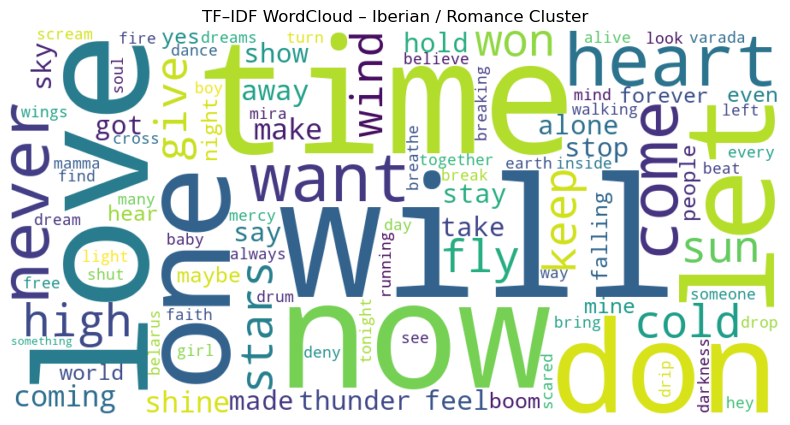

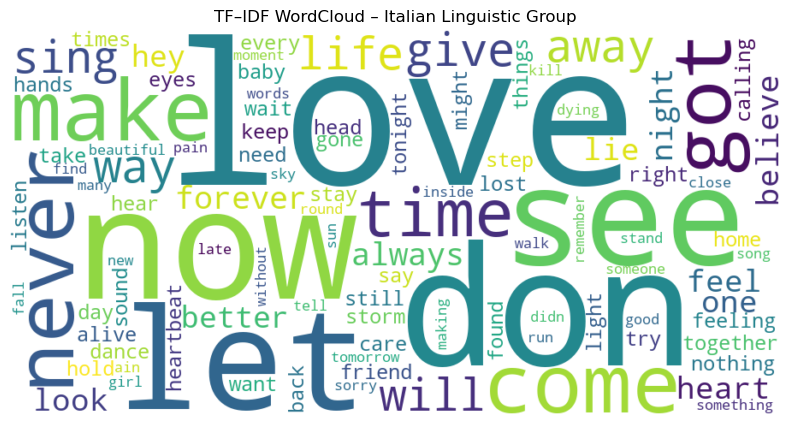

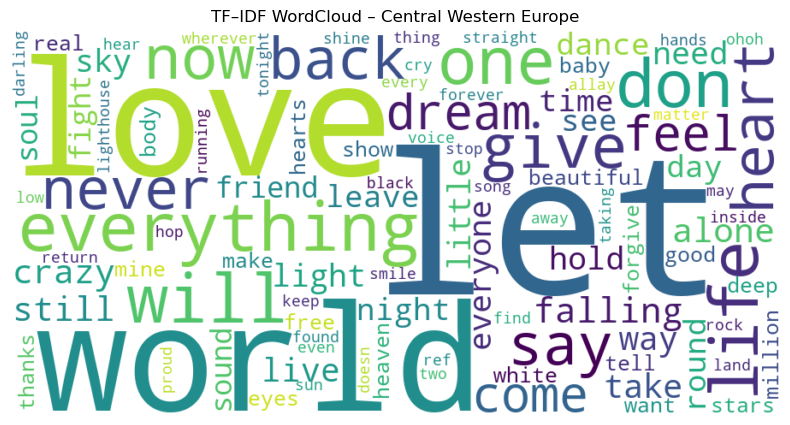

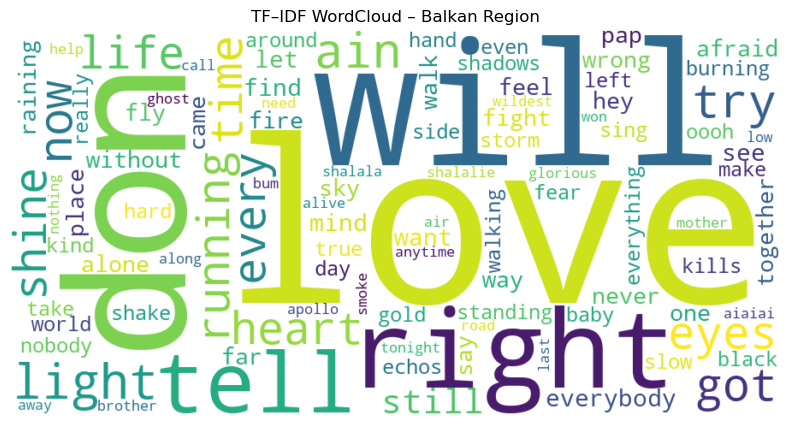

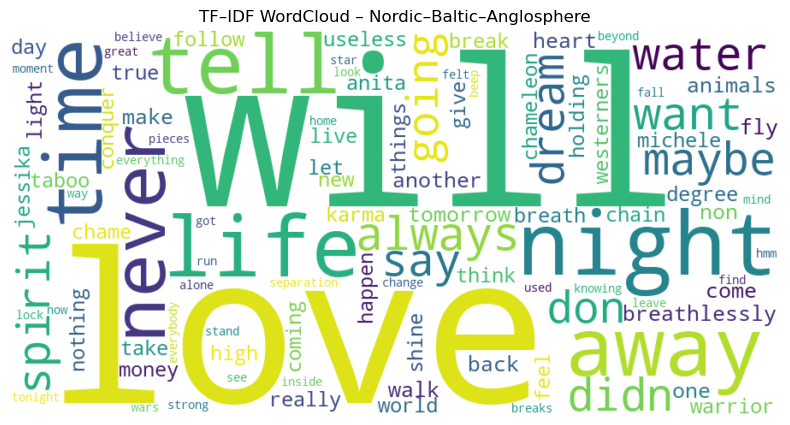

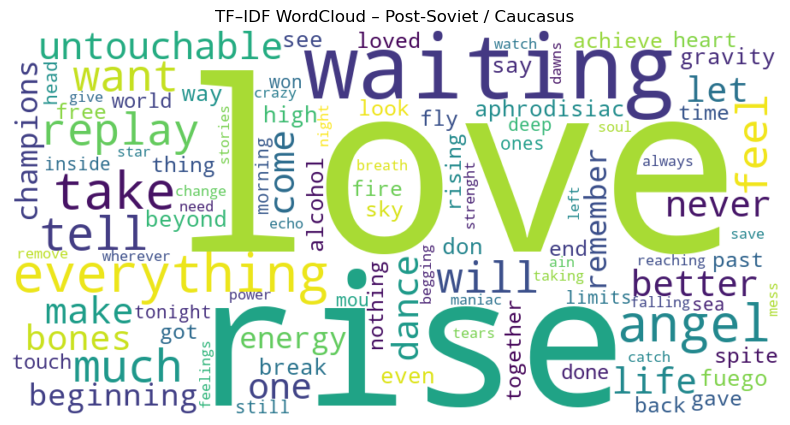

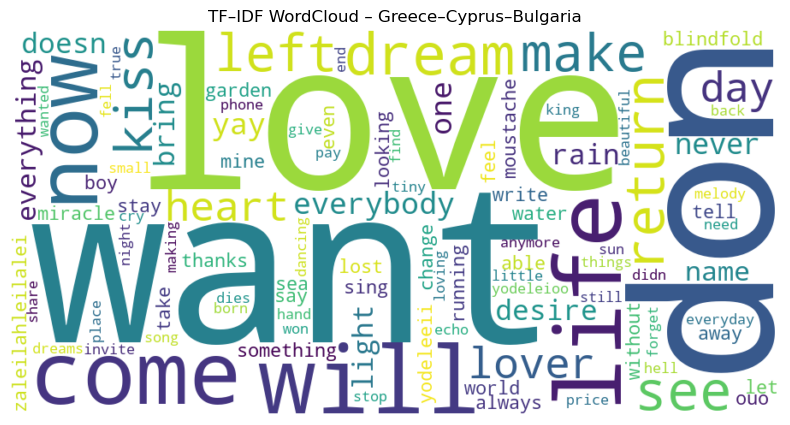

In [52]:
communities = df_lyrics["community_label"].dropna().unique()

for c in communities:
    mask = df_lyrics["community_label"] == c
    freqs = mean_tfidf_freqs(mask.values)
    top100 = top_k_freqs(freqs, k=100)

    wc = WordCloud(width=900, height=450, background_color="white")\
            .generate_from_frequencies(dict(zip(top100["word"], top100["mean_tfidf"])))

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"TF–IDF WordCloud – {c}")
    plt.show()


***Figure 21:** TF–IDF word clouds for each voting community (2010–2019).
Each panel displays the most distinctive words within a community’s lyrics, weighted by TF–IDF. While minor stylistic nuances appear, all communities share a broadly similar emotional vocabulary, dominated by recurring Eurovision themes such as love, time, and life. The lack of strong differentiation reinforces that lyrical content does not account for the voting blocs observed in the network structure.*

In [53]:
sent_by_comm = (
    df_lyrics.groupby("community_label")["sentiment"]
    .agg(["mean", "median", "std", "count"])
    .sort_index()
)

display(sent_by_comm)


mean    median       std  count
community_label                                               
Balkan Region              5.924236  5.890625  0.437792     57
Central Western Europe     6.075151  6.128081  0.378384     71
Greece–Cyprus–Bulgaria     6.146029  6.134889  0.343456     37
Iberian / Romance Cluster  6.001139  6.068901  0.426738     76
Italian Linguistic Group   6.068758  6.079434  0.381817    113
Nordic–Baltic–Anglosphere  6.065861  6.126255  0.388802     28
Post-Soviet / Caucasus     6.114913  6.177844  0.403738     26

In [54]:
genre_comm = pd.crosstab(df_lyrics["community_label"], df_lyrics["style"])
display(genre_comm)



style                      Ballad  Dance  Opera  Pop  Rock  Traditional
community_label                                                        
Balkan Region                  12      4      0   34     2            2
Central Western Europe         15      4      0   28    10            7
Greece–Cyprus–Bulgaria          8      4      0   14     2            1
Iberian / Romance Cluster      23      5      0   33     5            2
Italian Linguistic Group       24     15      2   57     7            5
Nordic–Baltic–Anglosphere       8      3      0   12     1            1
Post-Soviet / Caucasus          3      5      0   10     2            2

**Conclusion:**
Across sentiment, genre, and vocabulary, the voting communities show no clear lyrical or stylistic patterns that would explain their cohesion. Sentiment levels are almost identical across groups, genre mixes overlap heavily, and TF–IDF word clouds reveal a shared Eurovision vocabulary centred on themes like love, life, and time. This suggests that the voting blocs identified in the network analysis arise from regional or geopolitical dynamics, rather than similarities in the songs themselves. At the same time, the uniform nature of Eurovision lyrics limits how much differentiation text-based methods can detect, leaving open the possibility that deeper thematic or cultural factors lie beyond what simple NLP measures can capture.